<a href="https://colab.research.google.com/github/raularellano/BDpracticafinal/blob/main/Pr%C3%A1cticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Final
### Raúl Arellano López

En esta práctica voy a agrupar cada cliente y cada campaña en un cluster utilizando los algoritmos de clustering óptimos en cada caso y teniendo en cuenta el procesamiento previo de los datos.

Concretamente, voy a tratar los datos de clientes y de campañas para hacerlos aptos a los modelos de agrupación, analizando la estructura de los datos, tomando decisiones de tratamiento, viendo las posibles agrupaciones previas... Para ello utilizaré técnicas estadísticas sencillas y otras herramientas como el PCA, el T-SNE, o el UMAP. Eliminaré los valores atípicos y dejaré los datos limpios.

Una vez tengo los datos correctamente tratados, aplicaré sendos modelos de agrupaciónpara ambas tablas. De esta manerá obtendré el cluster al que pertenece cada individuo y cliente. 

Una vez he llegado hasta aqui, uniré los datos a la tabla de resultados de test y de entranamiento, y calcularé la probabilidad de éxito al aplicarle una campaña perteneceiente a un cluster a un cliente que pertenezca a un cluster concreto. Por último, utilizaré el RMSE para calcular el grado de precisión delmodelo.

Por último, generaré cinco clientes y cinco campañas completamente nuevos, y analizaré el cluster al que pertenecen y la campaña o cliente con el que deberían relacionarse para obtener el mayor éxito posible

Como Extra, realizaré (además delKmeias ya aplicado) otros 4 modelos de agrupación: Jerárquico, DBSCAN, Gaussian Mixture y HDBSCAN para obtener el modelo que mejor se ajusta a cada uno de los dos tipos de datos.

A lo largo de esta práctica, iré planteando algunas cuestiones de negocio que me parecen relevante mencionar y que he obtenido al desarrollar los ejercicios.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime as dt
import time
import math
import copy
from scipy.stats import iqr
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
#!pip install category_encoders
import category_encoders as ce
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
#!pip install umap
#!pip install umap-learn
import umap.umap_ as umap
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
#!pip install hdbscan
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
def plot_3d(component1,component2,component3, color, x,y,z, size=900):
  fig = go.Figure(data=[go.Scatter3d(
          x=component1,
          y=component2,
          z=component3,
          mode='markers',
          marker=dict(
              size=10,
              color=color,                
              colorscale=["firebrick", 'mediumseagreen' ,'darkmagenta', "steelblue",'orange' ],   
              opacity=1,
              line_width=1
          )
      )])
  # tight layout
  fig.update_layout(width=size,height=size, scene_camera = dict(eye=dict(x=x, y=y, z=z)))
  fig.layout.template = 'plotly_white'
  fig.show()

In [ ]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

In [ ]:
customers = pd.read_csv("https://raw.githubusercontent.com/raularellano/Customers/main/customers.csv")
campaigns = pd.read_csv("https://raw.githubusercontent.com/raularellano/Customers/main/campaigns.csv")
camp2cust= pd.read_csv("https://raw.githubusercontent.com/raularellano/Customers/main/campaigns_to_customers_launched.csv")

## Primera parte: Tratamiento de datos

### Pregunta 1.
Para hacer una posterior evaluación de los métodos desarrollados, divide el dataset campaigns_to_customers_launched.csv en training, validation y test.

In [ ]:
customers_train, customers_test = train_test_split(customers, test_size=0.3, random_state=123)

c2c_train = camp2cust[camp2cust.customer.isin(customers_train['customer_id'])]
c2c_test = camp2cust[camp2cust.customer.isin(customers_test['customer_id'])]
print("La variable c2c_train contiene {} registros, que suponen un {} del total \nLa variable c2c_test contiene {} registros, que suponen un {} del total".format(c2c_train.shape[0], c2c_train.shape[0]/camp2cust.shape[0], c2c_test.shape[0], c2c_test.shape[0]/camp2cust.shape[0]))

La variable c2c_train contiene 9414 registros, que suponen un 0.7004464285714286 del total 
La variable c2c_test contiene 4026 registros, que suponen un 0.2995535714285714 del total


Para realizar la práctica, he dividido el conjunto de datos en train y test (si bien es cierto que me planteé la posibilidad de dividir los datos en train, test y validation siguiendo esta <a href="https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c ">publicación</a>, me parecía que en este planteamiento teórico no tendría mucha utilidad generar una tabla de validación.)

Para dividir entre entrenamiento y test, tenía un problema: Si directamente dividia la tabla de resultados en test y entrenamiento, tendría clientes que pertenecerían tanto a test como a train (ya que a un mismo individuo, se le ofrecen distintas campañas). Para evitar este problema, decidí dividir el total de individuos en train y test con la función train_test_split() y luego usarlos para filtrar en la tabla de resultados los registros que se guardan como entrenamiento y los que se guardan como prueba, en funcion del cliente que intervenga. La division de la tabla de clientes no tiene más utilidad que esta a lo largo de la práctica, como ya se verá, he utilizado el conjunto de clientes a partir de aqui. 

Una vez que tengo la tabla de resultados correctamente dividida en train y test, voy a comentar como afectan los siguientes desarrollos a esta división:

El tratamiento de datos y la agrupacion por clusters de las preguntas 2 y 3 las he hecho sobre el conjunto de datos total, haciendo la división en la pregunta 4 al filtrar aquellos que pertenecen a test y los que pertenecen a train para calcular en cada caso una probabilidad de éxito distinta.

Pese a que en la tabla de resultaos de train y de test se encuentren los outliers que voy a quitar en el ejercicio 2, al hacer el inner join con los valores no outlier, no tendré en cuenta aquellos que estén fuera de rango para la predicción.

Me gustaría haber podido aplicar la tabla de validación en la Pregunta 7 para analizar algunas hipótesis de negocio que he planteado, pero la estructura de los datos hace que en los datos de train, al ser de tansolo el 60% del global, no genere el mismo numero de clusters que train o validación, imposibilitando la comparación de los distintos modelos. De todas formas, he dejado el código para esclarecer la mejor forma de obtener los tres conjuntos de datos según la publicación mencionada.



### Pregunta 2. Realiza las acciones adecuadas sobre customers.csv:

### Pregunta  2.1
Realiza una transformación adecuada del dataset customers.csv para su posterior procesamiento. (Tips: recuerda eliminar ids, transformar variables discretas, y cambiar fechas a días hasta el día actual, por ejemplo.)


Lo primero que hago, es analizar la estructura de los datos para luego poder tomar mejores decisiones respecto al tratamiento previo necesario para realizar los algoritmos de clustering o los modelos de reduccion dimensional o visualización.

In [ ]:
customers.head()

,customer_id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Response
0,0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,3,11,1
1,1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,3,11,0
2,2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,3,11,0
3,3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,3,11,0
4,4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,3,11,0



Primero, veo que prácticamente todas las columnas son numéricas, a excepcion de el nivel de educación Education y el estado civil Marital_Status. Además, hay columnas que contienen la identidad de los consumidores, por lo que debería eliminarlas, otras que contienen un numero constante (Z_CostContact o Z_Revenue) y otra, DT_Customer en formato de fecha, cuando debería ser un número.


In [ ]:
customers.describe()

,customer_id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,1119.500000,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.009375,3.0,11.0,0.149107
std,646.776623,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,559.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,3.0,11.0,0.000000
50%,1119.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,3.0,11.0,0.000000
75%,1679.250000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,3.0,11.0,0.000000
max,2239.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,3.0,11.0,1.000000


Lo primero que veo con la funcion describe() es que la variable Income tiene NAs al tener tansolo 2216 valores de los 2240 registros totales, por lo que lo trataré a continuación.

Confirmo que las variables Z_CostContact y Z_Revenue no tienen ningun tipo de varianza, al tomar valores constantes 3 y 11 por lo que las eliminaré para el análisis.

El resto de variables tiene distribuciones m´as o menoscorrectas, existiendo algun outlier que eliminaré más adelante en la práctica.

In [ ]:
pd.isnull(customers[[x for x in customers.columns[pd.isna(customers).any()].tolist()]]).sum()

Income    24
dtype: int64

De esta manera confirmo que launica variable con NAs es Income, con 24 registros no disponibles. Realmente, es una de las variables que mas senciallamente se puede imputar un valor como la media sin asumir que estemos cometiendo un gran error

In [ ]:
print(customers.Education.value_counts())
customers.Marital_Status.value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

Aquí, veo la frecuencia de los distintos valores de las variables categóricas que han escapado del análisis de variables numericas previo.
* En la variable Education se distribuyen de talmanera que no considero que haga falta un gran cambio para aplicar los modelos, más allá de cambiar a numérica.
* La variable Marital_Status si que tiene categorías con muy baja frecuencia, y que como explico a continuación, pueden agruparse con otras categorías mayoritarias.

El grueso del tratamiento de datos es el siguiente:

* Primero elimino cuatro variables: La variable ID ya que no aporta información adicional al index de la tabla, las variables Z_Revenue y Z_CostContact ya que recogen el mismo valor para cada individuo, por lo que es superflua para el análisis (de hecho, me he dado cuenta de esta situación al aplicar un PCA y ver que algunas CP no explicaban información (varianza 0)) y Year_Birth ya que la voy a sustituir directamente por la edad del cliente. Por otra parte, elimino la quita variable Dummie generada del One Hot Encoder ya que genera colinealidad entre los datos y no es necesaria, ya que la información la contienen el resto de dummies.

* Para lavariable de Educación, paso de las 5 categorías a una escala del 1 al 5 segun el nivel de educación. He decidido tratar así la variable educación por dos razones: si que existe una jerarquía en la distribución de las categorías y por que las variables dummie no me parece que representen correctamente esta dimensión (si tienes un Doctorado o un Master, tendrás una carrera también, pero no aparecerás como graduado en la dummie de Graduation) y por que un gran numero de variables explicativas del mismo rasgo (en el caso de hacer dummies) afectarían en gran medida a un analisis cluster si no se hace una reduccióndimensional previa. Mantengo en la tabla la variable original por si la necesito más adelante para hacer un análisis descriptivo.

* La variable DT_Customer la he pasado al número de años (con decimales) que hace desde que es cliente hasta la fecha de hoy. Lo he logrado pasando la fecha original a tiempo UNIX y restando ese valor a la fecha actual en UNIX. Por último, he dividido este valor entre el número de segundos que tiene un año (60*60*24*365) para tener el valor en años y no en segundos.

* La variable Year_Birth ha sido restada al año actual para crear la variable Edad.

* Para la variable Maritial_Status, decido aplicar un One Hot Encoder, pero realizando un tratamiento previo:

* Las categorías Casad@ (Married), Enparejad@ (Together), Solter@ (Single), Divorciad@ (Divorced) y Viud@ (Widow) tienen una frecuencia y una coherencia suficiente como para usarlas directamente, pero las categorías Sol@ (Alone), "Solo Se Vive una Vez" (You Only Live Once aka YOLO) y Absurdo (Absurd) son efectivamente absurdas y encajan en la categoría de Solter@. Por lo tanto, pasaremos de 8 a 5 categorías. Después, aplico el One HotEncoder para generar Dummies y elimino la ultima para evitar colinealidad.

* Para tratar los valores NA de Income, los completo con la media de esta variable (la proporción de NAs, el 1%, permite que esta sustitución no altere en gran medida a la variable) y certifico que ya no hay NAs en la tabla.

In [ ]:
customers_clean = customers.drop(columns=['customer_id', 'Z_Revenue', 'Z_CostContact', 'Year_Birth'])
customers_clean['Education_off'] = customers['Education']
customers_clean['Education'] = customers['Education'].apply(lambda id: {'Basic': 1,'2n Cycle': 2, 'Graduation': 3,'Master': 4, 'PhD': 5}[str(id)])
customers_clean['Dt_Customer'] = ((int(time.time())) - (pd.to_datetime(customers['Dt_Customer']).astype(int)/10**9))/(60*60*24*365)
customers_clean['Edad'] = 2022-customers['Year_Birth']
customers_clean['Marital_Status_off'] = customers_clean['Marital_Status']
customers_clean['Marital_Status'] = customers_clean['Marital_Status'].apply(lambda id: {'Married': 'Married', 'Together': 'Together', 'Single': 'Single', 'Divorced': 'Divorced',
                                                                            'Widow': 'Widow', 'Alone': 'Single', 'YOLO': 'Single', 'Absurd': 'Single'}[str(id)])
customers_clean = ce.OneHotEncoder(cols = ['Marital_Status']).fit(customers_clean).transform(customers_clean)
customers_clean = customers_clean.drop(columns=['Marital_Status_5'])
customers_clean['Income'] = customers_clean['Income'].fillna(customers_clean.Income.mean(), inplace=False)
pd.isnull(customers_clean[[x for x in customers_clean.columns[pd.isna(customers_clean).any()].tolist()]]).sum()

Series([], dtype: float64)

In [ ]:
customers_clean.head()

,Education,Marital_Status_1,Marital_Status_2,Marital_Status_3,Marital_Status_4,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Education_off,Edad,Marital_Status_off
0,3,1,0,0,0,58138.0,0,0,9.387230,58,635,88,546,172,88,88,3,8,10,4,7,0,1,Graduation,65,Single
1,3,1,0,0,0,46344.0,1,1,7.880380,38,11,1,6,2,1,6,2,1,1,2,5,0,0,Graduation,68,Single
2,3,0,1,0,0,71613.0,0,0,8.425586,26,426,49,127,111,21,42,1,8,2,10,4,0,0,Graduation,57,Together
3,3,0,1,0,0,26646.0,1,0,7.951613,26,11,4,20,10,3,5,2,2,0,4,6,0,0,Graduation,38,Together
4,5,0,0,1,0,58293.0,1,0,8.011887,94,173,43,118,46,27,15,5,5,3,6,5,0,0,PhD,41,Married


###Pregunta 2.2. 
¿Debes normalizar los datos?. Si es así, realiza la normalización. 

Para poder aplicar el PCA y para evitar que el K medias no tome unas variables como más relevantes que otras, es necesario escalar los datos, por lo que utilizo la funcion StandardScaler() para ello.

In [ ]:
customers_clean_scaled = StandardScaler().fit_transform(customers_clean.select_dtypes(np.number))

### Pregunta 2.3.
Puede ser interesante realizar un análisis descriptivo con algún mapa de correlación y un t-sne, pca o similar para ver como se distribuyen los datos y eliminar outliers (recuerda eliminarlos también de la tabla que relaciona clientes y campañas)


Voy a hacer primero un TSNE para ver como se agrupan los datos según este modelo y si hay individuos que no se agrupan correctamente.

Después, para identificar estos individuos, relizaré un Análisis de Componentes Principales y obtendré cual de los individuos es un outlier según el mean_squared_error entre la proyección en las CP y su predicción al reducir la dimensión (guardando el 80% de la información)

In [ ]:
from sklearn.decomposition import PCA
pca_tsne = PCA()
pca_result_tsne = pca_tsne.fit(customers_clean_scaled)
tsne = TSNE(n_components=3, perplexity = math.sqrt(len(customers_clean_scaled))).fit_transform(customers_clean_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



**Primero, voy a realizar un T-SNE sobre los datos que he codificado en el ejercicio anterior.** Me parece adecuada al ser una herramienta de visualización de conjuntos de datos de alta dimensión,como creo que es el caso, y para identificar posibles outliers y eliminarlos del análisis para que no condicionen los algoritmos de Kmedias y su comparación con los registros de test.

Antes de todo, **aplico un PCA sencillo sobre los datos** (una vez escalados), para poder seleccionar las 3 variables que mayor información van a explicar de los datos, y asi graficar el T-SNE de la mejor maner posible. 

Realizo el T-SNE y lo grafico, como se puede ver en el gráfico, **aparecen una serie de grupos correctamente diferenciados** (debemos recordar que las distancias entre individuos intragrupo son reales, pero entre grupos, se escoge la distancia que más convenga a la gráfica, por lo que son irreales).**Para establecer el perplexity del T-SNE, he tenido en cuenta la siguiente  <a href="https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 ">publicación</a>.** (raiz cuadrada del número de registros con el que se construye el T-SNE, (2.240 ^ 1/2 = 47), por lo que la perplexity es igual a 47.

A priori, **puedo identificar 3 o 4 grupos principales, unos tantos más de un tamaño menor y valores que no pertenecen a ninguno de los grupos y que, por tanto, presupongo como atípicos, a falta de confirmación por otros algoritmos, así como un grupo muy pequeño que podría ser 'el grupo de Outliers'**

En principio, **no puedo separar por grupos al ser un análisis no supervisado**, pero más adelante utilizo algoritmos que me indican al grupo al que pertence cada individuo en función de una serie de inputs (DBSCAN) y **vuelvo a graficar el T-SNE, pero teniendo en cuenta el grupo al que se supone que pertenece cada individuo según el DBSCAN, para comprobar que, efectivamente, los grupos generados por el TSNE se contrastan con el DBSCAN.**

In [ ]:
plot_3d(tsne[:,0], tsne[:,1], tsne[:,2], 'cadetblue', 1.5, 1.5, 0)

A continuación, **voy a realizar un DBSCAN para asignar a cada registro un grupo de pertenencia, y así poder certificar que el T-SNE se ha aplicado correctamente**

Para aplicar el algorítmo de clustering, lo primero que hago es **establecer el *número mínimo* de individuos necesario para generar un grupo**. He decidido que este numero sea igual a **el número de variables que contienen los datos por dos** (`min_samples=np.shape(x)[1]*2`) y no un número menor para ser bastante conservador a la hora de determinar un valor outlier (Un individuo necesitará estar cerca de muchos otros para poder pertenecer a un grupo y no ser denominado como outlier)

Lo segundo que decido es **el valor de *epsilon***, es decir, el radio del cículo centrado en el individuo que va a establecer si dos individuos están suficientemente cercanos como para pertenecer al mismo grupo o si son muy lejanos, según el criterio de el vecino más cercano. Para ello, he creado las distancias entre los individuos según el criterio indicado, y he realizado una gráfica de codo para determinar el valor óptimo de epsilon. He decidido que tenga un valor de 5.5, tal y como se ve en la gráfica.

En ambas medidas he intentado ser bastante conservador, en la medida de lo posible, para que los outlier sean realmente valores extremos y no posibles nuevos entrantes a la empresa a los que se les está comenzando a aplicar una campña para analizar el resultado o por que la empresa estuviese buscando diversificar su linea de productos.

**Todo ello lo he realizado debido a la información de la siguiente <a href="https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd">publicación.</a>**

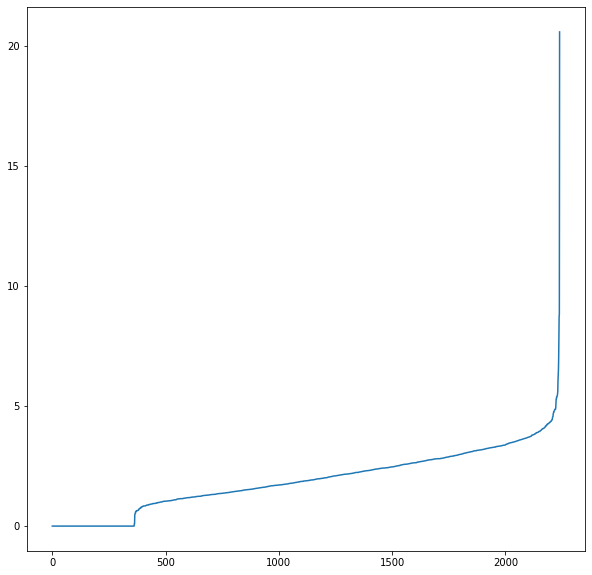

In [ ]:
neighbors = NearestNeighbors()
neighbors_fit = neighbors.fit(customers_clean_scaled)
distances, indices = neighbors_fit.kneighbors(customers_clean_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,10))
plt.plot(distances)
plt.show()

In [ ]:
clustering = DBSCAN(eps=5.5, min_samples=np.shape(customers_clean_scaled)[1]*2).fit(customers_clean_scaled)
y_pred_x = clustering.fit_predict(customers_clean_scaled)

plot_3d(tsne[:,0], tsne[:,1], tsne[:,2], y_pred_x, 1.5, 0, 0)

Efectivamente, hay 39 outliers identificados por el DBSCAN según los inputs introducidos. (Más adelante comentaré este resultado comparandolo con otras técnicas de identificación de valores atípicos)

Realmente, según lo que se ve en la gráfica (y recordando que en el T-SNE las distancias INTRA-grupo son reales pero las INTER-grupos  son irreales) podría identificar dos tipos de valores atípicos teniendo en cuenta el problema de negocio que se nos plantea:

* Valores extremos individuales, es decir, aquellos que se alejan de los valores no atípicos de forma individual. Serían clientes que nada tienen que ver con el negocio y que han participado en las campañas pero siendo completamente heterogéneos al conjunto de clientes habituales del negocio.

* Valores extremos agrupados, es decir, aquellos resentes en elgrupominoritario de valores atípicos. Estos individuos no son lo suficientemente representativos en número como para pertenecer a los clientes habituales o crear un nuevo grupo de clientes. Puede deberse a que la estrategia del negociose enfoque a ofrecer su producto a un nuevo segmento de cliente y esta estrategia se acabe de implantar de tal manera que, pese a que hay una cantidad de clientes a los que la empresa se esté dirigiendo, su número no es suficientemente alto como para dejar de ser heterogéneos a los clientes habituales o generar un nuevo grupo de clientes habituales2.

 A continuación, voy a continuar analizando los valores atípicos realizando un Análisis de Componentes Principales. Para ello, voy a realizar lo siguiente:

 * 1º Voy a aplicar el PCA al conjunto de datos directamente, incluyendo los valores fuera de rango
 
 * 2º Obtengo las coordenadas de todos losindividuos en TODAS las CP. Los individuos que no sean Outliers, serán correctamente representados en las primeras CP (ya que son aquellas que representan el grueso de la población) pero aquelloscuyos valores sean más extremos, no estarás correctamente representados en estas primeras componentes, sino en las últimas (ya que las últimas CP son las que mejor representan los valores atípicos)
 
 * 3º Me quedaré con las CP que expliquen el 70% de la población (9 componentes, ya que son aquellos con autovalor mayor de 1) y que representen correctamente a los valores más homogéneos y mal a los individuos extremos
 
 * 4º Aplicaré la inversa del PCA con 9 CP (que contiene el 70% de la información) sobre el total de individuos. De esta manera, obtendré las nuevas Componentes Principales en las que estarán correctamentente representados los indviduos dentro de valores normales, y mal representados los individuos fura de rango
 
 * 5º Por último, aplico el Error Cuadrático Medio entre la coordenada que tiene el individuo en la primera CP al aplicar en un primer momento el PCA y el valor que toma al realizar la inversa del PCA. Aquellos individuos con mayor MSE serán valores fuera de rango

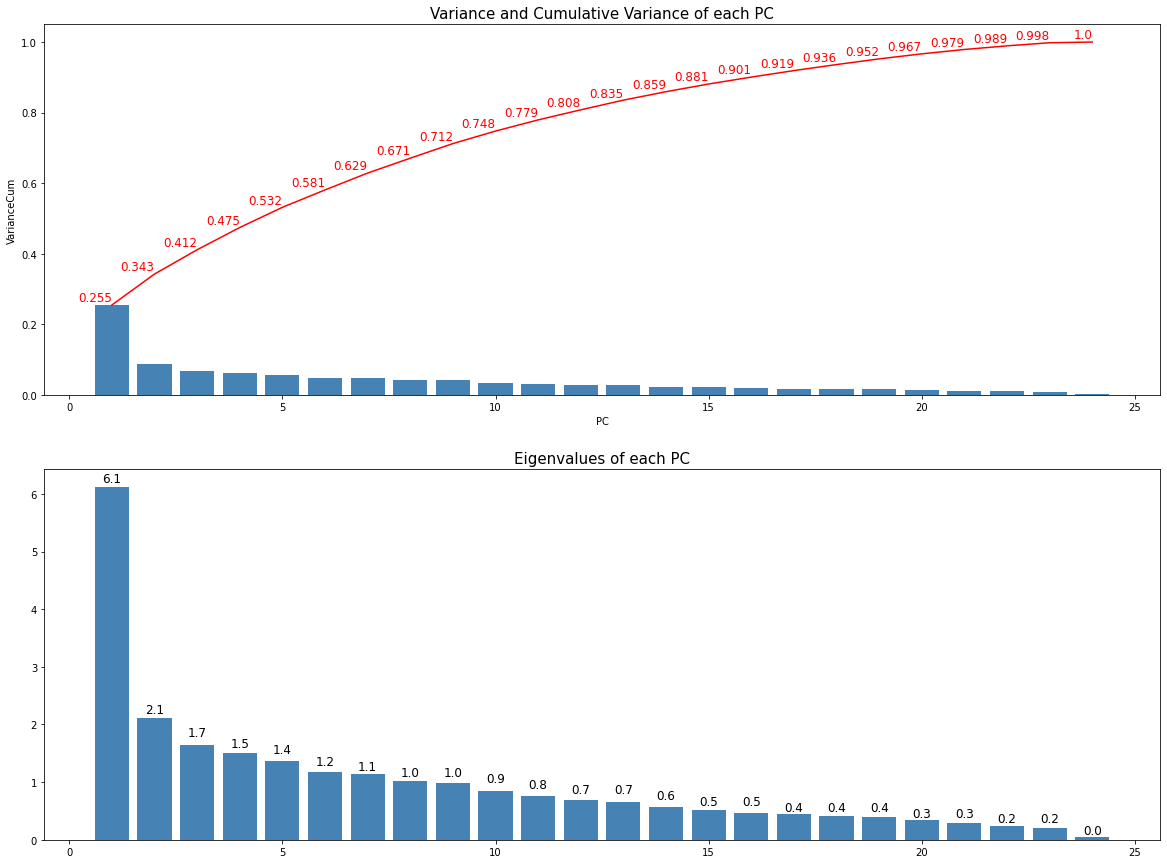

In [ ]:
summary = pd.DataFrame({'Variance' : pca_result_tsne.explained_variance_ratio_,
                          'VarianceCum' : pca_result_tsne.explained_variance_ratio_.cumsum(),
                          'Eigenvalue' : pca_result_tsne.explained_variance_,
                          'PC' : np.arange(1, len(pca_result_tsne.explained_variance_ratio_)+1)})

plt.figure(num = 3, figsize=(20,15))

plt.subplot(211)
plt.bar(data = summary,
         height = 'Variance', x = 'PC', color="steelblue")
sns.lineplot(data = summary,
         y = 'VarianceCum', x = 'PC', color="red")
for i, v in enumerate(round(summary.VarianceCum,3)):
    plt.text(summary.PC.tolist()[i], v+0.01, str(v), ha='right', 
             fontsize=12, color = 'red')
plt.title('Variance and Cumulative Variance of each PC', size=15)

plt.subplot(212)
plt.bar(data = summary,
         height = 'Eigenvalue', x = 'PC', color="steelblue")
for i, v in enumerate(round(summary.Eigenvalue,1)):
    plt.text(summary.PC.tolist()[i], v+.1, str(v), ha='center', 
             fontsize=12, color = 'black')
plt.title('Eigenvalues of each PC', size=15)
plt.show()

Con 9 CP explicamos el 70% de la información, por lo que va a ser el nº de CP que vamos a utilizar para generar el modelo sobre el que calcularemos la inversa. En esta inversa, los valores que más se desvíen de los registros originales serán aquellos que no se explican correctamente en las CP que explican la mayor parte de la varianza, sino que se explicarán en las CP marginales, por lo que serán individuos fuera de rango.

Por otra parte, la primera vez que realicé el PCA (no en esta, donde he llevado a cabo una serie de transformaciones adicionales) encontré situación muy interesante: las últimas 4 CP no explicaban nada de información, lo que quiere decir que hay una alta correlación entre 3 variables y que deberían ser extraídas del análisis. Al realizar una tabla de correlaciones, vi que las variables Z_Revenue y Z_CostContact recogían el mismo valor para cada individuo, por lo que es superflua para el análisis. Además, no había eliminado la ultima de las variables dummie, por lo que, pese a no estar correladas al 100%, existia colinealidad entre las variables. Esta última dummie no contiene información adicional ya que se puede calcular como la diferencia respecto al resto de dummies.

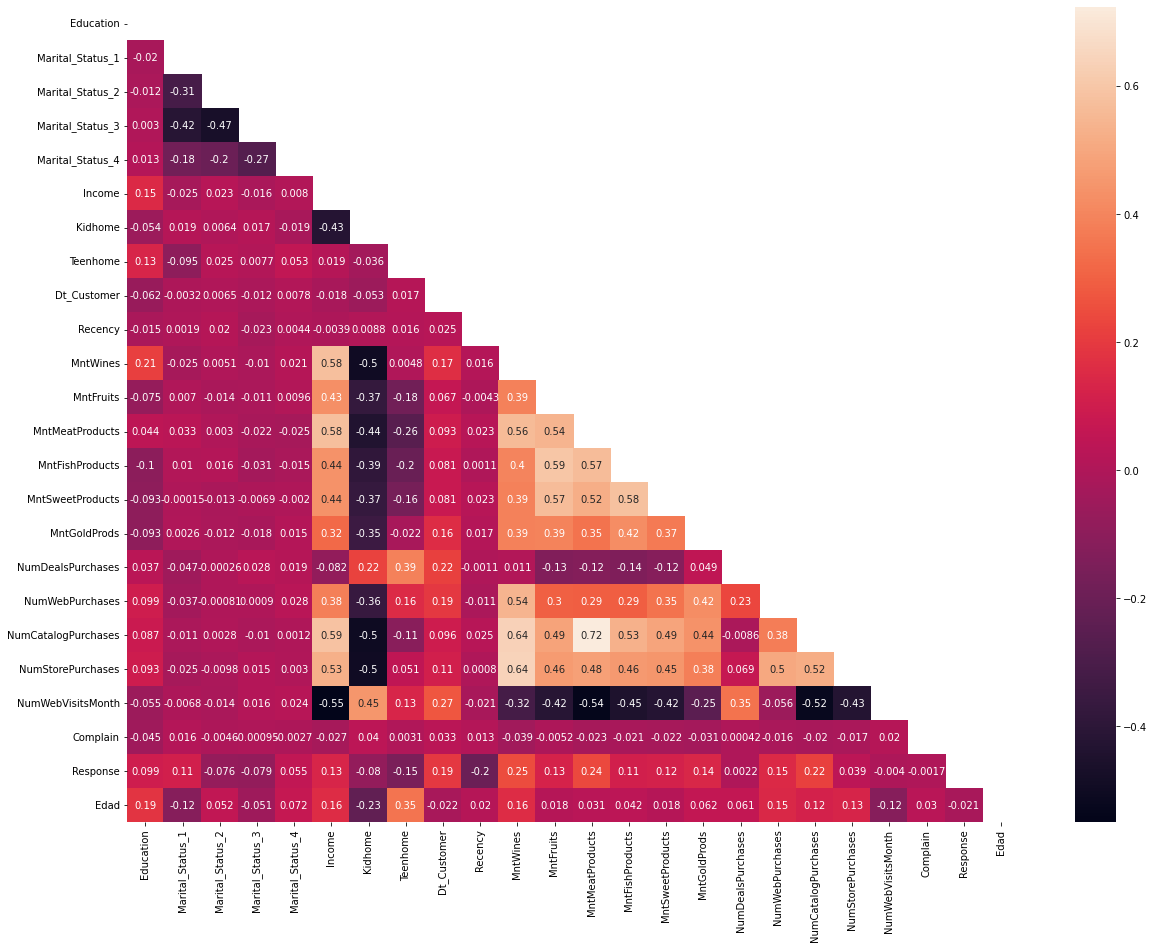

In [ ]:
correlation = customers_clean.loc[:, customers_clean.columns]
corr_matrix_p = correlation.select_dtypes(include = ['int', 'float']).corr(method = 'pearson')

mask_p = np.zeros_like(corr_matrix_p)
mask_p[np.triu_indices_from(mask_p)]=True

plt.figure(num = 3, figsize=(20,15))
sns.heatmap(corr_matrix_p, annot=True, annot_kws={"size": 10}, mask = mask_p)
plt.show()

In [ ]:
from sklearn.decomposition import PCA 
PCA = PCA(n_components = 9)
pca = PCA.fit(customers_clean_scaled)
testComponents = pca.transform(customers_clean_scaled)
customers_clean_rec = pca.inverse_transform(testComponents)

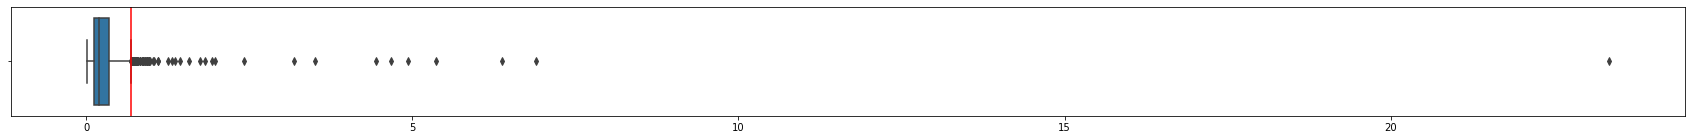

In [ ]:
MSE = np.array([mean_squared_error(customers_clean_scaled[i,], customers_clean_rec[i,]) for i in range(len(customers_clean_scaled))])
plt.figure(num = 3, figsize=(30,2))
sns.boxplot(x=MSE)
plt.axvline(x = np.quantile(MSE, .75) + 1.5*iqr(MSE), color = 'red')
plt.show()

In [ ]:
print(np.sort([mean_squared_error(customers_clean_scaled[i,], customers_clean_rec[i,]).round(2) for i in range(len(customers_clean_scaled))]).tolist()[-39:])
collections.Counter(y_pred_x)

[0.88, 0.9, 0.91, 0.92, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98, 1.02, 1.04, 1.1, 1.1, 1.26, 1.31, 1.37, 1.44, 1.58, 1.75, 1.82, 1.93, 1.97, 2.42, 3.19, 3.51, 4.45, 4.67, 4.93, 5.37, 6.38, 6.89, 23.34]


Counter({-1: 39, 0: 2201})

Si establecemos que un MSE por encima de 0.9 (debido a la distribución de este cálculo, que hace que un valor de 0.9 se encuentre por encima de 1,5 veces el Recorrido Intecturtílico más elcuartil 3 (que podría ser una definición de outlier)) encontramos que unos 38 valores se encuentran por encima de 0.9 en MSE. Si compaamos con que el DBSCAN ha determinado en el grupo de Outliers (aquellos individuos que no ha sido capaz de agrupar en otros grupos) 39 individuos, podríamos tenerlos en cuenta como individuos atípicos y eliminarlos del análisis (siempre y cuendo hayamos establecido los parámetros del DBSCAN de forma correcta, cosa que creo que he hecho).

In [ ]:
np.corrcoef(customers['Complain'], y_pred_x)

array([[ 1.        , -0.73081712],
       [-0.73081712,  1.        ]])

Me parecía interesante remarcar una relación que he visto terminando la práctica, y es la fuerte correlación entre los individuos fuera de rango y aquellos que se han quejado (Complain). Esta relación tiene mucho sentido, ya que aquellos individuos que no encajan entre nuestros clientes habituales se han podido sentir tratados de una forma diferente y por lo tanto quejarse, lo que explicaría la correlación entre las personas que se quejan y aquellas que toman valores atípicos. Por lo tanto, el grupo deoutliers agrupados podría ser un grupo de clientes insatisfechos. (tras un par de comprobaciones, a medida que el número de outliers calculado por el DBSCAN se acercamás al numero de individuos que se ha quejado, mayor es la correlación, lo que indica que la relacion entre los individuos que se quejan y aquellos outliers más extremos, es prácticamente perfecta, lo que refuerza la hipótesis de negocio que he planteado).

Por lo tanto, lo siguiente que hago es eliminar los individuos extremos, utilizando la funcion isin() y drop() para que elimine aquelllos registros cuyo individuo pertenezca a la definicion de outlier dada por el DBSCAN y que coincide con el análisis de CP teniendo en cuenta el Error Cuadrático Medio. Los he eliminado de la tabla original para repetir el T-SNE y corroborar que efectivamente se han eliminado tanto los indviduos agrupados en elgrupo de outliers como aquellos que erancompletamente extremos.

In [ ]:
customers_clean['Outlier'] = y_pred_x
customers_clean_Preg2 = customers_clean[customers_clean.Outlier.isin([0])].drop(columns=['Outlier'])
customers_clean2_scaled = StandardScaler().fit_transform(customers_clean_Preg2.select_dtypes(np.number))

pca_result_tsne = pca_tsne.fit(customers_clean2_scaled)
tsne2 = TSNE(n_components=3, perplexity = math.sqrt(len(customers_clean2_scaled))).fit_transform(customers_clean2_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
plot_3d(tsne2[:,0], tsne2[:,1], tsne2[:,2], 'purple', 1.5, 1.5, 0) 
plot_3d(tsne[:,0], tsne[:,1], tsne[:,2], [np.nan if y_pred_x[x] == -1 else 0 for x in range(len(y_pred_x))], 1.5, 0, 0)

### Pregunta 2.4.
Haz un clustering haciendo uso de K-means, de la base de datos de customers. Recuerda optimizar el valor adecuado de componentes (seleccionar adecuadamente la K).

En este ejercicio voy a implementar el algoritmo de Kmedias sobre los atos de customers limpios y escalados directamente (reservo hacer un PCA y aplicar sobre los componentes el algoritmo para la pregunta 7)

Para ello, lo primero que hago es un pequeño análisis de correlaciones para comprobar que la variable Complain no puede ser utilizada en el análisis (lo más seguro es que gran cantidad de los outliers tomasen el valor 1 en esta variable. Por ello, es necesario eliminarla del análisis antes de comenzar con el K medias

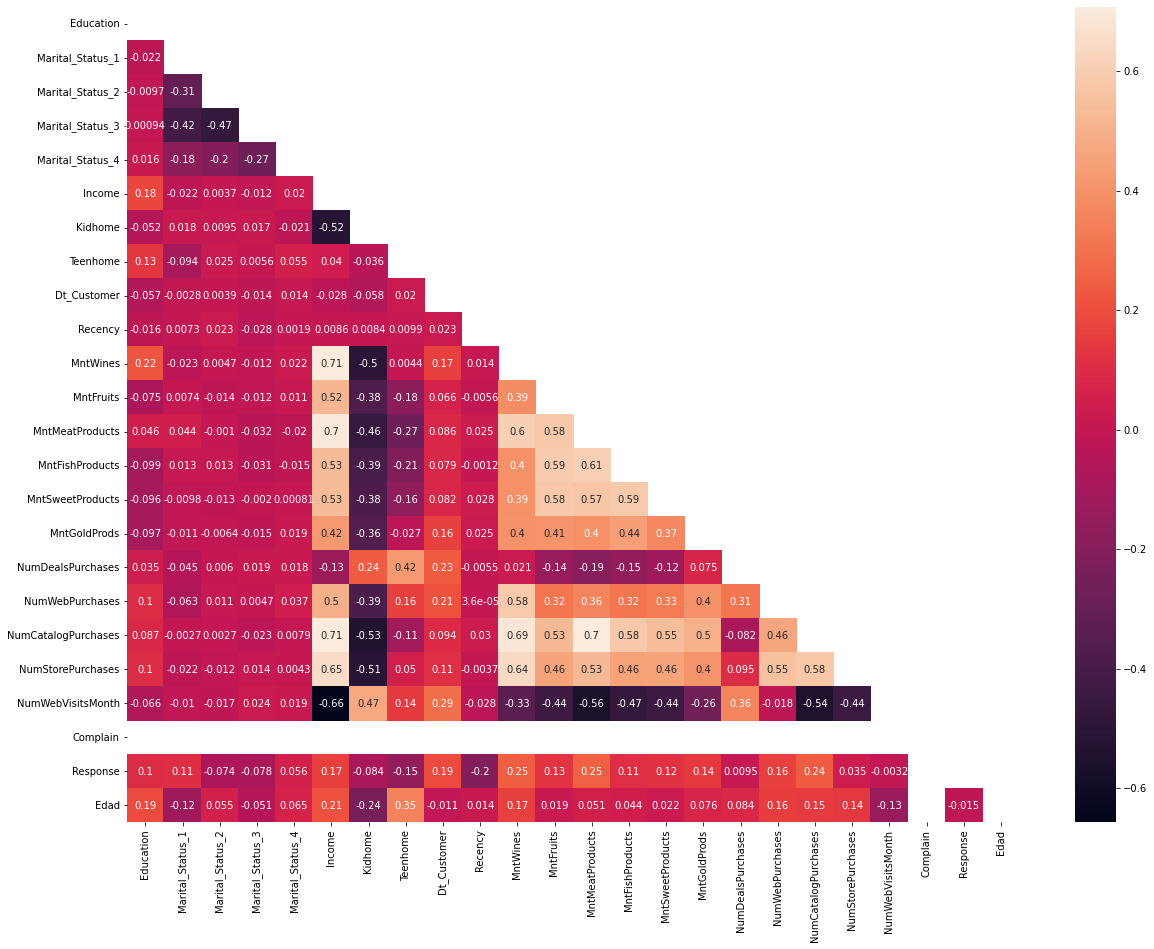

In [ ]:
correlation = customers_clean_Preg2.loc[:, customers_clean_Preg2.columns]
corr_matrix_p = correlation.select_dtypes(include = ['int', 'float']).corr(method = 'pearson')

mask_p = np.zeros_like(corr_matrix_p)
mask_p[np.triu_indices_from(mask_p)]=True

plt.figure(num = 3, figsize=(20,15))
sns.heatmap(corr_matrix_p, annot=True, annot_kws={"size": 10}, mask = mask_p)
plt.show()

Una vez tengo los datos limpios, los escalo con la funcion StandardScaler y calculo el número de clusters que mejor se adapta a estos datos según elmétodo de Kmedias. A demás del criterio del codo,he utilizado otros criterios más elaborados que he encontrado en esta <a href="https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad">publicación.</a> (debido a la gran necesidad de tiempo que llevan algunos modelos para poder aplicarse, no los he procesado).

El resultado es que se deberían de coger entre 2 o 3 Clusters de clientes. Para decidier el valor exacto, más adelante he preparado una simulación con la distribución de los individuos en cada grupo en función del número de clusters y el centroide de cada grupo repitiendo la operacion entre 2 y 5 grupos

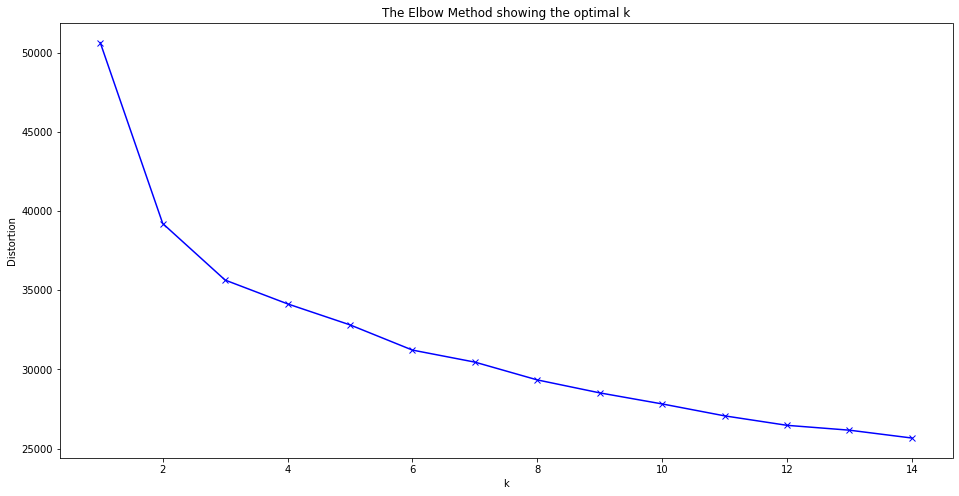

In [ ]:
scaler_customers = StandardScaler().fit(customers_clean_Preg2.select_dtypes(np.number).drop(columns=['Complain']))
customers_clean2_scaled = scaler_customers.transform(customers_clean_Preg2.select_dtypes(np.number).drop(columns=['Complain']))

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(customers_clean2_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#from yellowbrick.cluster import KElbowVisualizer
#model = KMeans()

#visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
#visualizer.fit(customers_clean2_scaled)        
#visualizer.show()        

#scores = []
#centers = list(range(2,30))
#for center in centers:
 #   scores.append(get_kmeans_score(customers_clean2_scaled, center))
    
#plt.plot(centers, scores, linestyle='--', marker='o', color='b');
#plt.xlabel('K');
#plt.ylabel('Davies Bouldin score');
#plt.title('Davies Bouldin score vs. K')

Para poder graficar rápidamente los individuos almacenando la mayor información posible, he hecho un Análisis de Componentes Principales. De esta manera, podré utilizar las coordenadas de cada individuo en las CP que almacenen mayor información para representar los clusters de la manera más realista posible.

A continuación se presentan los individuos posicionados en sus coordenaas respecto las 3 primeras CP y agrupados según el cluster al que pertenecen teniendo en cuenta 3 clusters que, como explicaré más adelante, es la opción que voy a tomar.

También aplico laagrupación alposicionamiento de cada individuo según el T-SNE que he realizado previamente, para ver si los grupos que se han predecido antes corresponden más o menos con los clusters. Como se puede ver, los cluesters se situan ordenadamente dentro del TSNE también

Porúltimo, hago un UMAP para representar los grupos según los grupos que genera este sistema de visualizacion y efectivamente es coherente con la agrupación del Kmedias.

In [ ]:
kmeans_cust = KMeans(n_clusters=3, random_state=123, max_iter = 10000)
y_pred_clientes = kmeans_cust.fit_predict(customers_clean2_scaled)

projected = pca.fit_transform(customers_clean2_scaled)

In [ ]:
plot_3d(projected[:,0], projected[:,1], projected[:,2], y_pred_clientes, 1, 1.5, 1)
plot_3d(tsne2[:,0], tsne2[:,1], tsne2[:,2], y_pred_clientes, -1.5, -1.5, 1.5)

reducer = umap.UMAP(random_state = 42, n_components = 3)
embedding = reducer.fit_transform(customers_clean2_scaled, y = y_pred_clientes)

plot_3d(reducer.embedding_[:,0], reducer.embedding_[:,1], reducer.embedding_[:,2], y_pred_clientes, 1, -1, 1.5)

Por ultimo, para certificar que efectivamente son 3 el numero de clusters qu deberia utilizar, he utilizado un bucle for para repetir 5 veces el k medias con distinto numero de clusters. De esta manera, puedo ver gráficamente como se agrupan los individuos (teniendo las 2 primeras componentes principales como ejes) en funcion del número de clusters que indico, así como la posicion del centroide de cada cluster.

Tengo en cuenta que 2 clusters que se solapen en este gráfico no representan al 100% la realidad del análisis (puede ser que, aun que parezcan muy juntos en este gráfico, la variable qu diferencia la pertenencia a un cluster o a otro no esté correctamente representada en las dos primeras componentes principales, por lo que, aaunque paareciese solapado, puede ser que no lo estuviese si se tuviesen en cuenta más dimensiones). Sin embargo, es la mejor representación posible en dos dimensiones.

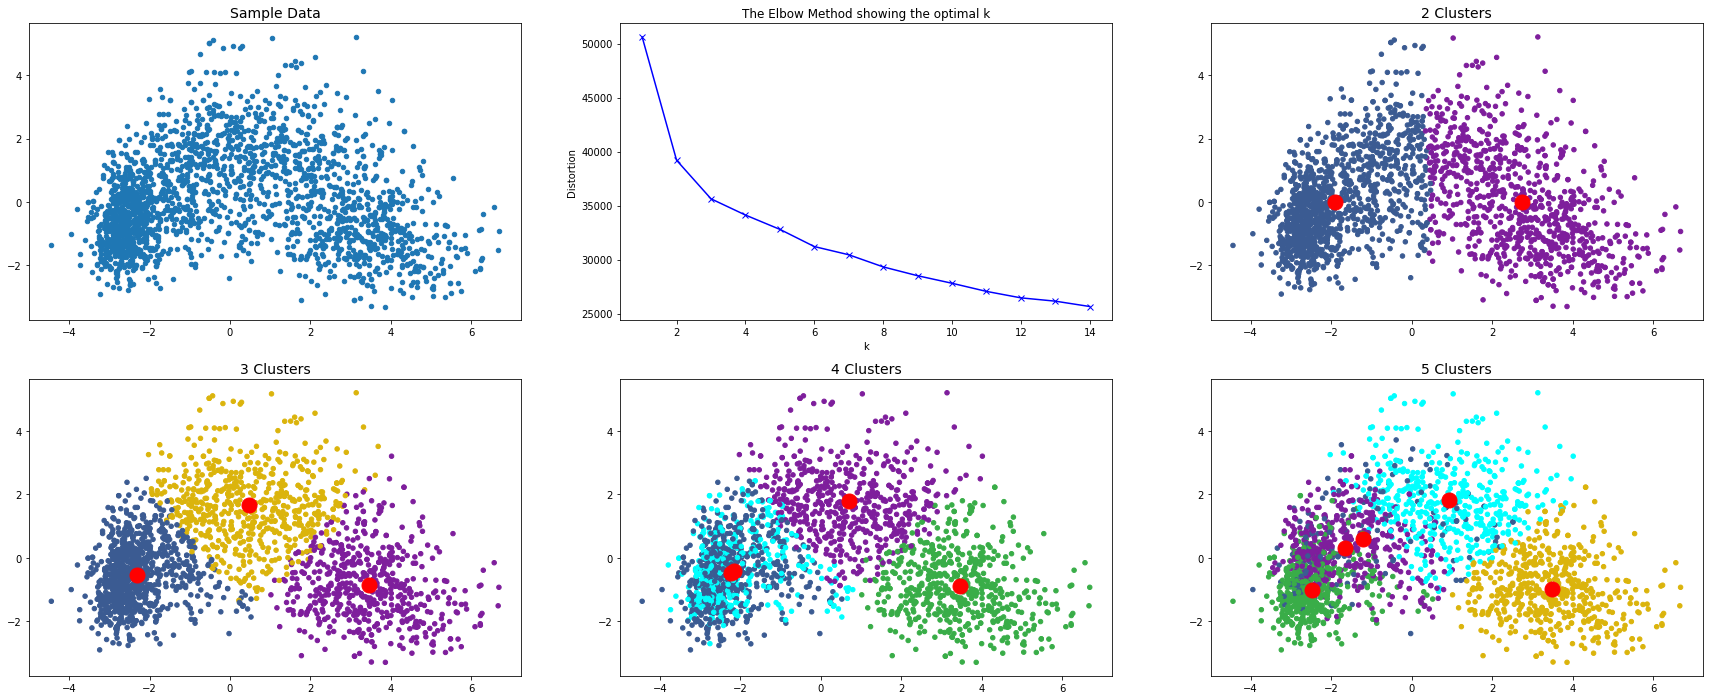

In [ ]:
data = projected
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'gold', 'cyan', 'purple']))

clusters = [0]*4
centroids = [0]*4
for i in range(2, 6):
  alg = KMeans(n_clusters=i, random_state=123, max_iter = 10000)
  clusters[i-2] = alg.fit_predict(customers_clean2_scaled)
  centroids[i-2] = [item[[0,1]] for item in pca.transform(alg.cluster_centers_)]


plt.figure(figsize=(30,12))
plt.subplot(231)
plt.scatter(data[:,0], data[:,1], s=20, cmap=cmap)
plt.title('Sample Data', fontsize=14)

plt.subplot(232)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.subplot(233)
centroide = pd.DataFrame(centroids[0])
plt.scatter(data[:,0], data[:,1], c=clusters[0], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('2 Clusters', fontsize=14)

plt.subplot(234)
centroide = pd.DataFrame(centroids[1])
plt.scatter(data[:,0], data[:,1], c=clusters[1], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('3 Clusters', fontsize=14)

plt.subplot(235)
centroide = pd.DataFrame(centroids[2])
plt.scatter(data[:,0], data[:,1], c=clusters[2], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('4 Clusters', fontsize=14)

plt.subplot(236)
centroide = pd.DataFrame(centroids[3])
plt.scatter(data[:,0], data[:,1], c=clusters[3], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('5 Clusters', fontsize=14)
plt.show()

centroides_5_customers = alg.cluster_centers_

Tal y como se puede ver, tanto 4 como 5 clusters sería un tanto ineficiente (teniendo en cuenta la definicion de la gráfica del codo, incluir un cuarto o quinto cluster a pensas supondría un cambio, lo que es menos eficiente que aplicar 2 o 3 clusters)

Respecto la diferencia entre 2 y 3 clusters, realmente no tengo un dato que determine que es mejor utilizar 3 que 2 clusters, pero teniendoen cuenta el objetivo del análisis, utilizar 3 clusters ajusta mucho mejor los individuos para poder calcular la probablidad de éxito de las campañas, porlo que es el objetivo del problema de negocio lo que me lleva a decantarme por 3 clusteers (si bien, soy consciente de que podría estar incurriendo en sobre ajuste con esta decisión).

Por último, agrego el cluster al que pertenece cada individuo a la tabla limpia y sin outliers de datos para poder emplearlo en los siguientes ejercicios.

In [ ]:
customers_clean_Preg2['Cluster_Customer'] = y_pred_clientes+1
customers_clean_Preg2

,Education,Marital_Status_1,Marital_Status_2,Marital_Status_3,Marital_Status_4,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Education_off,Edad,Marital_Status_off,Cluster_Customer
0,3,1,0,0,0,58138.0,0,0,9.387230,58,635,88,546,172,88,88,3,8,10,4,7,0,1,Graduation,65,Single,3
1,3,1,0,0,0,46344.0,1,1,7.880380,38,11,1,6,2,1,6,2,1,1,2,5,0,0,Graduation,68,Single,1
2,3,0,1,0,0,71613.0,0,0,8.425586,26,426,49,127,111,21,42,1,8,2,10,4,0,0,Graduation,57,Together,3
3,3,0,1,0,0,26646.0,1,0,7.951613,26,11,4,20,10,3,5,2,2,0,4,6,0,0,Graduation,38,Together,1
4,5,0,0,1,0,58293.0,1,0,8.011887,94,173,43,118,46,27,15,5,5,3,6,5,0,0,PhD,41,Married,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,3,0,0,1,0,61223.0,0,1,8.614627,46,709,43,182,42,118,247,2,9,3,4,5,0,0,Graduation,55,Married,2
2236,5,0,1,0,0,64014.0,2,1,7.622846,56,406,0,30,0,0,8,7,8,2,5,7,0,0,PhD,76,Together,2
2237,3,0,0,0,1,56981.0,0,0,7.995449,91,908,48,217,32,12,24,1,2,3,13,6,0,0,Graduation,41,Divorced,2
2238,4,0,1,0,0,69245.0,0,1,7.998189,8,428,30,214,80,30,61,2,6,5,10,3,0,0,Master,66,Together,2


### Pregunta 3. Realiza las acciones adecuadas sobre campaigns.csv:

En este ejercicio voy a hacer un proceso similar al del anterior perco cambiando de datos:
* Primero, voy a tratar los datos, eliminando aquellos que no aporten informacion o que estén repetidos
* Segundo, escalar las variables para poder aplicar los modelos de clustering
* Tercero, análisis descriptivo de los datos en profundidad (en este caso hay menos variables, por lo que es factible profundizar)
* Cuarto, aplicar el K medias para obtener los distintos clustrs de campañas de marketing, teniendo en cuenta el numero de grupos optimo.

### Pregunta 3.1 
Transformación del dataset si es necesario.


Los datos se componen de distintas variables que contienen la identificación de la campaña, la probabilidad de que pertenezca a campaña de un producto de comida o bebida (Calculado mediante NLP tipo TF-IDF, LDA o similar), el numero de dias que duró la campaña, el precio original del producto, eldescuento en euros y el nombre de la campaña

In [ ]:
campaigns.head()

,campaign_id,prob_food,prob_drink,outdate,price,discount,name
0,0,0.54,0.22,4.0,40.39,19.35,campaign_1
1,1,0.47,0.48,4.0,39.30,20.94,campaign_2
2,2,0.56,0.28,10.0,30.19,10.88,campaign_3
3,3,0.50,0.37,11.0,31.30,12.70,campaign_4
4,4,0.55,0.44,2.0,39.68,20.69,campaign_5


In [ ]:
campaigns.describe()

,campaign_id,prob_food,prob_drink,outdate,price,discount
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.514400,0.473400,5.270000,92.406000,11.395800
std,29.011492,0.252684,0.236448,3.659373,67.994949,5.458951
min,0.000000,0.030000,0.040000,1.000000,27.710000,3.830000
25%,24.750000,0.320000,0.300000,2.000000,36.390000,7.990000
50%,49.500000,0.540000,0.450000,5.000000,69.780000,10.030000
75%,74.250000,0.692500,0.662500,9.000000,126.125000,13.860000
max,99.000000,0.990000,0.990000,11.000000,202.260000,22.060000


Para tratar los datos, he definido como indice el numero de identificaión de cada campaña (realmente no haría falta por que es igual al indice que ya habia, pero de estamanera, ante nuevas campañas o datos desordenados, el código seguiría teniendo buen resultado). He eliminado las columnas de campign_id y name ya que referían la misma información que ya está en el índice de la tabla. Por último, he establecido el descuento que se hace en cada campaña como un porcentaje respecto del preciooriginal, y no como un valor monetario

In [ ]:
campaigns_clean = campaigns
campaigns_clean.index = campaigns.campaign_id
campaigns_clean = campaigns.drop(columns=['campaign_id', 'name'])
campaigns_clean['discount'] = np.round(campaigns.discount/campaigns.price, 2)
campaigns_clean.head()

,prob_food,prob_drink,outdate,price,discount
campaign_id,,,,,
0,0.54,0.22,4.0,40.39,0.48
1,0.47,0.48,4.0,39.30,0.53
2,0.56,0.28,10.0,30.19,0.36
3,0.50,0.37,11.0,31.30,0.41
4,0.55,0.44,2.0,39.68,0.52


### Pregunta 3.2 
Normaliza si es necesario.

Por ahora no sería necesario escalar, ya que para la Pregunta 3.3. sigo utilizando los datos originales. De todos modos, como lo voy a necesitar en la Pregunta 3.4, escalo ahora con la función StandardScaler()

In [ ]:
scaler_campaigns = StandardScaler().fit(campaigns_clean.select_dtypes(np.number))
campaigns_clean_scaled = scaler_campaigns.transform(campaigns_clean.select_dtypes(np.number))

### Pregunta 3.3 
Quizá sea interesante un pequeño análisis descriptivo.

He creado una serie de gráficos según lo que creo que se adapta mejor a cada tipo de dato para analizar distintas cosas que me ayuden a la hora de generar los clusters:
* Matriz de correlaciones entre las distintas variables de la tabla

* Comparación entre la distribuciónde prob_food y prob_drink, permite ver bimodalidad

* Histograma de la distribución del precio

* Gráfico de dispersión entre prob_food y prob_drink, para ver si podría haber grupos

* Gráfico de dispersión entre prob_food y prob_drink, relacionado por duración, para ver si podría haber grupos

* Gráfico de dispersión entre prob_food y prob_drink, relacionado con precio, para ver si podría haber grupos

* Histogramas de comparación de distribución de precio  de descuento.

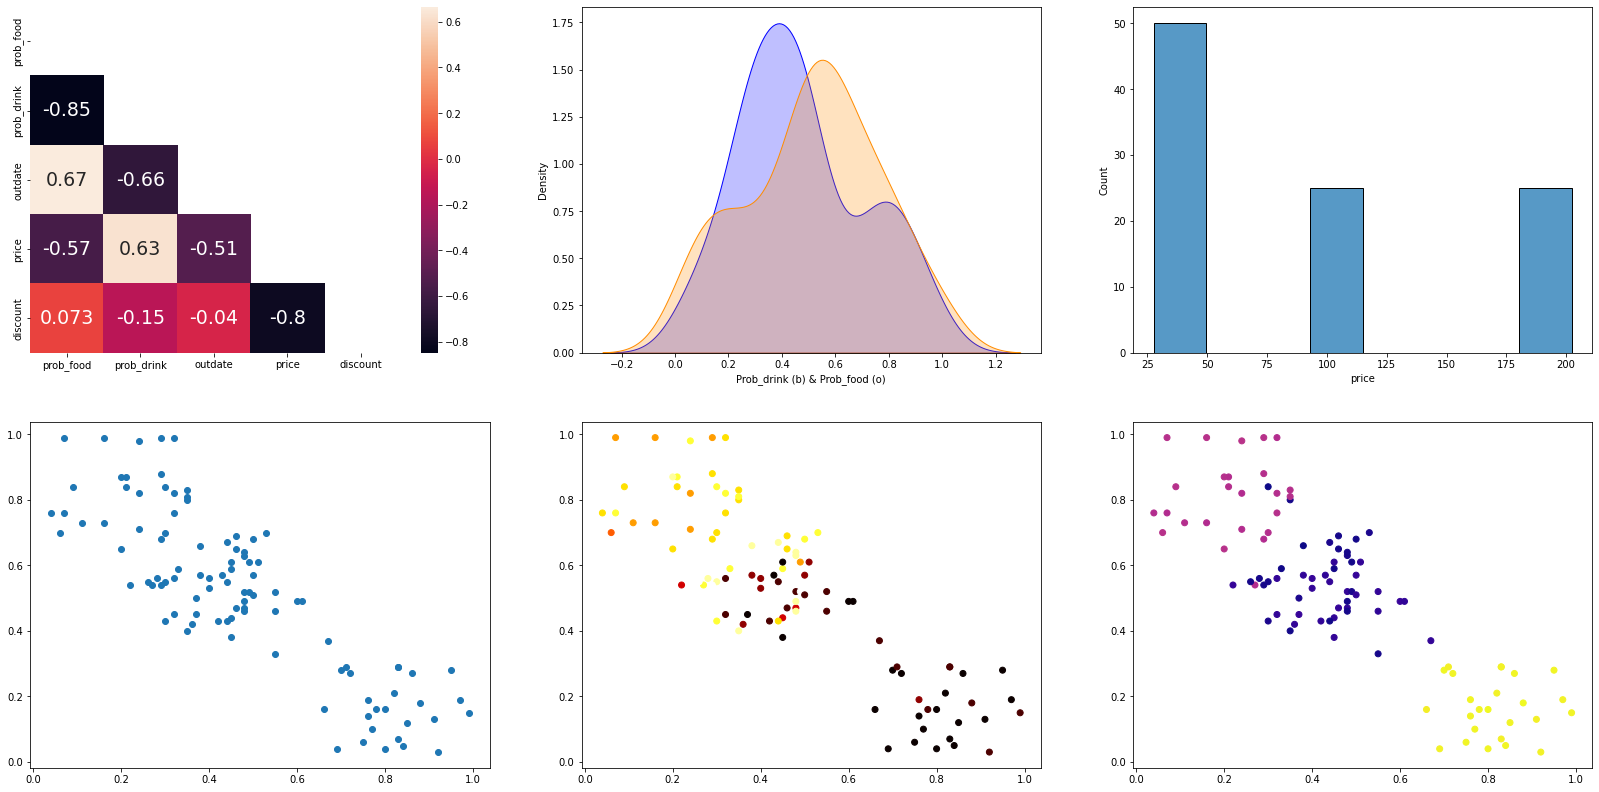

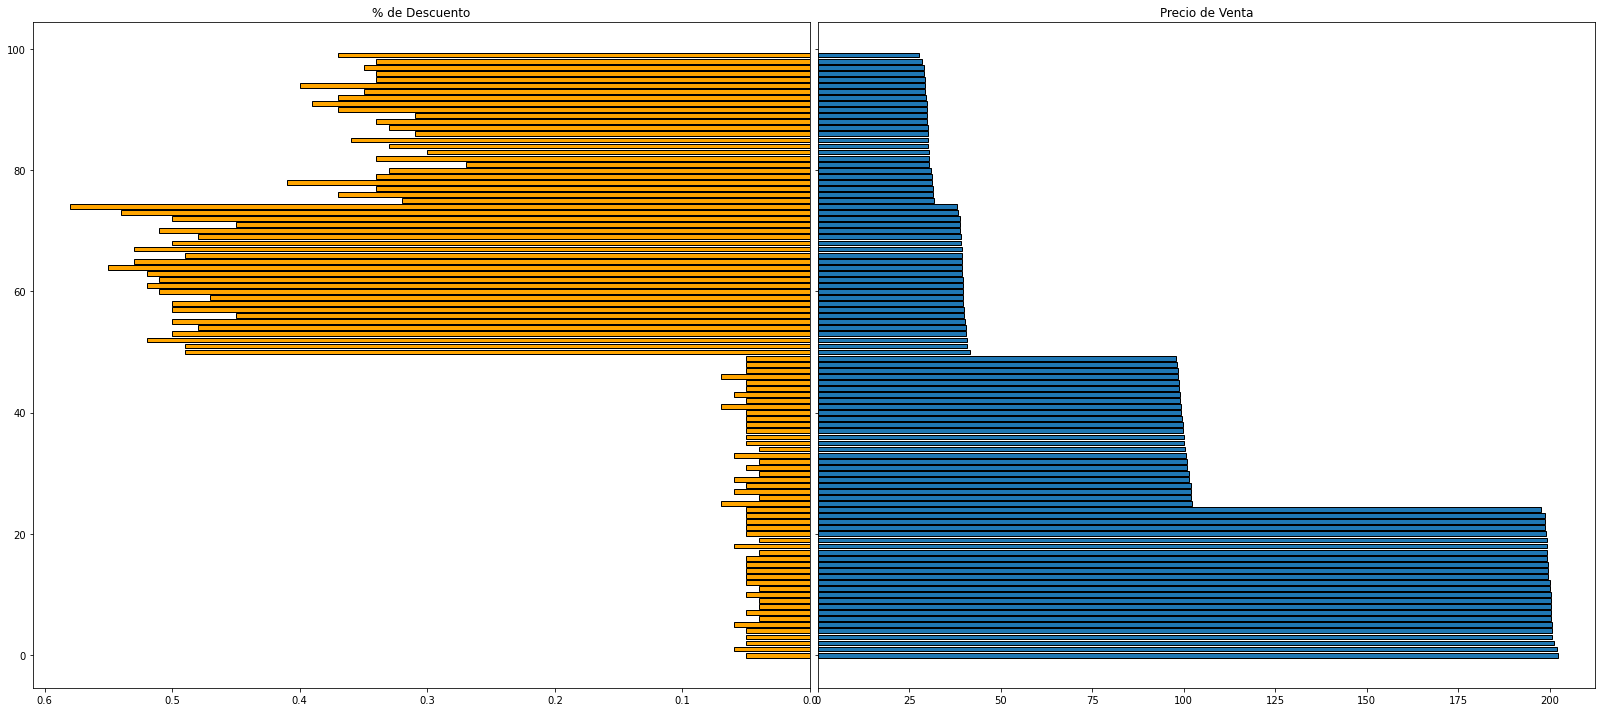

In [ ]:
correlation = campaigns_clean.loc[:, campaigns_clean.columns]
corr_matrix_p = correlation.select_dtypes(include = ['int', 'float']).corr(method = 'pearson')

mask_p = np.zeros_like(corr_matrix_p)
mask_p[np.triu_indices_from(mask_p)]=True

plt.figure(figsize=(28,14))

plt.subplot(231)
sns.heatmap(corr_matrix_p, annot=True, annot_kws={"size": 19}, mask = mask_p)
plt.subplot(232)
sns.kdeplot(campaigns_clean.prob_drink, shade=True, color = 'blue')
sns.kdeplot(campaigns_clean.prob_food, shade=True, color = 'darkorange')
plt.xlabel('Prob_drink (b) & Prob_food (o)')
plt.subplot(233)
sns.histplot(x=campaigns_clean.price, stat="count", edgecolor='black')
plt.subplot(234)
plt.scatter( x=campaigns_clean.prob_drink, y=campaigns_clean.prob_food)
plt.subplot(235)
plt.scatter( x=campaigns_clean.prob_drink, y=campaigns_clean.prob_food, c = campaigns_clean.outdate, cmap = 'hot')
plt.subplot(236)
plt.scatter( x=campaigns_clean.prob_drink, y=campaigns_clean.prob_food, c = campaigns_clean.price, cmap = 'plasma')
plt.show()

sorted = campaigns_clean.sort_values(by=['price'], ascending = False)

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(22.35,10))
axes[0].barh(y=range(len(sorted)),edgecolor = 'black', width=sorted.discount, color='orange')
axes[1].barh(y=range(len(sorted)),edgecolor = 'black', width=sorted.price)
axes[0].set(title='% de Descuento')
axes[1].set(title='Precio de Venta')
axes[0].invert_xaxis()
fig.tight_layout()
fig.subplots_adjust(wspace=0.01)
plt.show()

De los anteriores gráficos, puedo extraer el siguiente análisis:
* Matriz de correlaciones entre las distintas variables de la tabla: 
 
 Hay correlaciones muy fuertes entre las variables, especialmente entre las de probabilidad y la duración por un lado y el precio y el descuento por otro. Es por estas correlaciones, por lo que he definido las siguientes gráficas

* Comparación entre la distribuciónde prob_food y prob_drink, permite ver bimodalidad:

 Ambas distribuciones tienen una moda (prob_drink en torno al 0.3 y prob_food entrono al 0.6) y un punto con frecuencia bastante alta (prob_drink en torno al 0.9 y prob_food entrono al 0.1) lo que puede ser un primer indicio de la existencia de grupos y deque estas dos variables son utiles para determinar la pertenencia a un grupo o a otro.

* Histograma de la distribución del precio:

 Claramente se puede apreciar como hay 3 grupos de precio completamente diferenciados (de 25 a 50 euros, de 90 a 115 euros y de 180 a 210 euros) sin tener valores fuera de estos grupos, lo que es una clara evidencia de que es una variable perfecta para aplicar al algoritmo de clustering.

* Gráfico de dispersión entre prob_food y prob_drink, para ver si podría haber grupos: 

 Se pueden ver en torno a 3 grupos de valores, aquellas campañas 'puras', ya sea de bebida(abajo a la derecha) o de comida (arriba a la izquierda) y aquellas que son mixtas o que el NLP no ha sabido clasificar correctamente (en el centro) que quizas pertenezcan a una tercera categoría (productos de limpieza por ejemplo)

* Gráfico de dispersión entre prob_food y prob_drink, relacionado por duración, para ver si podría haber grupos:

 Mismo gráfico anterior pero teniendo en cuenta la duración de la campaña. Se ve como las campañas de comida, toman valores más oscuros y, por tanto, duran más tiempo y las campañas de bebida toman valores más claros y, por tanto, duran menos tiempo.

* Gráfico de dispersión entre prob_food y prob_drink, relacionado con precio, para ver si podría haber grupos:

 Se puede ver perfectamente como simplemente esta agrupación ya podría suponer una agrupacion por clusters de por si. Se ve como cad auno de lo 3 grupos descritos en esta gráfica pertenece a un grupo de precio distinto de los vistos en el hitograma.

* Histogramas de comparación de distribución de precio  de descuento:

 Por último, me parecía muy interesante ver este gráficodebido a la fuerte correlacion negativa entre el precio y el descuento de una campaña (ya tenia esta idea en la cabeza cuando vi que estas dos variables eran exactamente iguales en una primera tabla de datos). Se puede ver como claramente las campañas de productos con un mayor precio tienen un descuento muy inferior a aquellas campañas con productos más baratos, cuyo descuento es mayor. Es muy relevante lo significativo de estas variables, y como pueden servir como discriminatorias a la hora de agrupar en el K medias.

Distribución de precios ordenada y distribución de descuentos ¿Mayor % de descuento en productos más caros?

### Pregunta 3.4 
Haz un clustering haciendo uso de K-means, de la base de datos de customers. Recuerda optimizar el valor adecuado de componentes.

Siguiendo el mismo proceso que en laPregunta 2, he generado un gráfico de codo para analizar el número óptimo de grupos en los que se pueden dividir las campañas, así como un Análisis de Componentes Principales para poder  ver gráficamente en 2D la mayor cantidad de información posible. En este caso, se ve claramnte como se generan 4 clusters de campañas, que ya se podían ver en los datos del PCA.

Podría parecer que igual con 3 clusters es suficiente, pero es la tercera CP (que refleja mayor información) en la que se ve como claramente son grupos distintos. Por lo tanto, podemos decir que la variable que discrimina si un inividuo pertenece a uno de estos dos grupos o al otro está fuertemente correlacionada con la tercera Componente Principal.

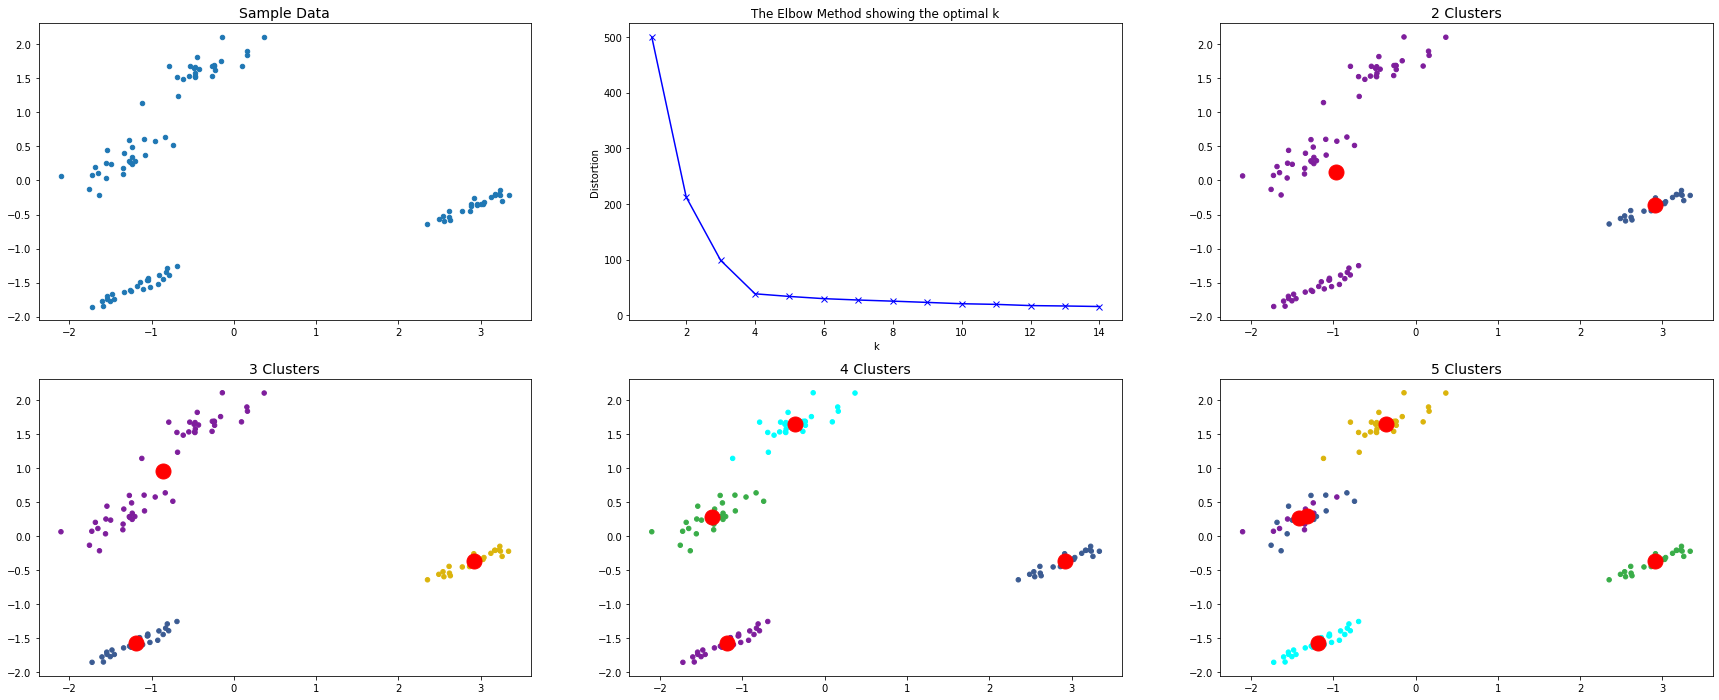

In [ ]:
from sklearn.decomposition import PCA 
PCA = PCA(n_components = 5)
pca = PCA.fit(campaigns_clean_scaled)
projected2 = pca.fit_transform(campaigns_clean_scaled)

data = projected2
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'gold', 'cyan', 'purple']))

clusters = [0]*4
centroids = [0]*4
for i in range(2, 6):
  alg = KMeans(n_clusters=i, random_state=123, max_iter = 10000)
  clusters[i-2] = alg.fit_predict(campaigns_clean_scaled)
  centroids[i-2] = [item[[0,1]] for item in pca.transform(alg.cluster_centers_)]


plt.figure(figsize=(30,12))
plt.subplot(231)
plt.scatter(data[:,0], data[:,1], s=20, cmap=cmap)
plt.title('Sample Data', fontsize=14)

plt.subplot(232)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(campaigns_clean_scaled)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.subplot(233)
centroide = pd.DataFrame(centroids[0])
plt.scatter(data[:,0], data[:,1], c=clusters[0], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('2 Clusters', fontsize=14)

plt.subplot(234)
centroide = pd.DataFrame(centroids[1])
plt.scatter(data[:,0], data[:,1], c=clusters[1], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('3 Clusters', fontsize=14)

plt.subplot(235)
centroide = pd.DataFrame(centroids[2])
plt.scatter(data[:,0], data[:,1], c=clusters[2], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('4 Clusters', fontsize=14)

plt.subplot(236)
centroide = pd.DataFrame(centroids[3])
plt.scatter(data[:,0], data[:,1], c=clusters[3], s=20, cmap=cmap)
plt.plot(centroide[0], centroide[1], 'ro', markersize=15)
plt.title('5 Clusters', fontsize=14)
plt.show()

centroides_5_campaigns = alg.cluster_centers_

Por último, creo una nueva columna, en los datos originales,que determine el cluster al que pertenece cada campaña para poderlo utilizar en los siguientes ejercicios.

In [ ]:
kmeans_camp = KMeans(n_clusters=4, random_state=123, max_iter = 10000)
y_pred_campaign = kmeans_camp.fit_predict(campaigns_clean_scaled)

campaigns_clean['Cluster_Campaigns'] = y_pred_campaign+1
campaigns_clean

,prob_food,prob_drink,outdate,price,discount,Cluster_Campaigns
campaign_id,,,,,,
0,0.54,0.22,4.0,40.39,0.48,3
1,0.47,0.48,4.0,39.30,0.53,3
2,0.56,0.28,10.0,30.19,0.36,2
3,0.50,0.37,11.0,31.30,0.41,2
4,0.55,0.44,2.0,39.68,0.52,3
...,...,...,...,...,...,...
95,0.84,0.21,8.0,99.37,0.05,4
96,0.43,0.30,9.0,31.65,0.32,2
97,0.83,0.35,8.0,100.31,0.04,4


In [ ]:
plot_3d(data[:,0], data[:,1], data[:,2], campaigns_clean.Cluster_Campaigns, 0, 0, 2)

### Pregunta 4.
Haciendo uso del dataset de entrenamiento de campaigns_to_customers_launched.csv, calcula el valor esperado de éxito para clúster de campañas mostrado a cada clúster de clientes. Este valor esperado, podría representar, de forma aproximada, por cada combinación de clusters campaña-cliente, la probabilidad de éxito al ofrecer una campaña al azar de un clúster de campañas a un cliente al azar de un clúster de clientes. 

A continuación, cojo la tabla que enfrenta clientes y campañas de entrenamiento, y elimino la columna unamed ya que no es necesaria para este análisis. Además, de las dos tablas de clientes (y el cluster al que pertenecen) y campañas (y el cluster al que pertenecen) estraigo tan solo las columnas que contienen la pertenencia a un cluster y utilizo el índice de cada uno de estos dos vectores para saber el cliente o campaña al que pertenece cada registro.

Lo siguiente que hago es un join entre el dataset de resultados de entrenamiento y el cluster al que pertenece cada campaña y cliente haciendo un doble join. 

Por último hago un reset_index para evitar errores ya que tengo una columna con la identidad del cliente y una columna con la identidad de la campaña que se aplica en cada caso.

Por último una columna con todo unos que me será muy útil para ahorrar tiempo al hacer el group by.

*Nota: No hay que preocuparse por los outliers, por que, como ya he comentado al realizar la división entre train y test, al hacer el inner join de los individuos de train (que si que contiene outliers) y de la tabla de los clusters para cada uno de todos los clientes (que no contiene ya outliers), los individuos que están presentes en ambas tablas (los que no son outliers) se mantendrán, mientras que aquellas que tan solo están presentes en una de las tablas (los fuera de rango) quedarán fuera del join.*

In [ ]:
c2c_train = c2c_train.loc[:, c2c_train.columns != 'Unnamed: 0']
c2c_train.head()

,customer,campaign,result
0,1650,34,1
1,1168,85,0
2,2142,36,0
3,1536,12,0
6,1300,68,1


In [ ]:
campaigns_ready = campaigns_clean[['Cluster_Campaigns']]
customers_ready = customers_clean_Preg2[['Cluster_Customer']]

join_train = c2c_train.set_index('campaign')
join_train = join_train.join(campaigns_ready).join(customers_ready, on = 'customer').reset_index().rename(columns={'index': 'campaign'})
join_train['unos'] = [1]*len(join_train)

Como se puede apreciar, me queda una tabla con la siguiente estructura:
* Customer: con la identificación de cada cliente en el registro correspondiente (tiene tan solo los ID de los clientes de train excluyendo los outliers)

* Cluster_customer: Con el cluster al que pertenece cada cliente según el K medias aplicado ( del 1 al 3)

* Result: Resultado de aplicar la campaña correspondiente a ese cliente en concreto, pudiendo ser 1 o 0

* Campaign: Identificación de la campaña en el registro correspondiente (del 0 al 99)

* Cluster_campaign: Cluster al que pertenece cada campaña en función del K medias realizado (del 1 al 4)

* Unos: Vector de unos que servirá en el groupby() para contar sin necesidad de realizar otras funciones.

In [ ]:
join_train.head()

,campaign,customer,result,Cluster_Campaigns,Cluster_Customer,unos
0,0,2038,0,3,1.0,1
1,0,453,0,3,2.0,1
2,0,876,0,3,2.0,1
3,0,1699,0,3,3.0,1
4,0,783,0,3,1.0,1


Por último, aplico el groupby() agrupando por la combinación de Cluster_Campaigns y Cluster_Customer y aplicando la función sum() (así obtengo una suma para cada una de las combinaciones de las 2 variables en cada una del resto de variables).

Por último, lo único que me queda hacer es dividir la suma de resultados positivos en una combinación de Cluster_Customers - Cluster_Campaigns entre la suma del total de registros (de unos) de esa combinación, calculando de esta manera la probabilidad condicionada.

Un ejemplo, quedaría como: La probabilidad de que un individuo perteneciente a un cluster de cliente 1 acepte una campaña de un cluster de campañas 1 es de un 15.17%

In [ ]:
grouped = join_train.groupby(['Cluster_Campaigns', 'Cluster_Customer']).sum()
resultado_train = grouped.result/grouped.unos
resultado_train

Cluster_Campaigns  Cluster_Customer
1                  1.0                 0.156977
                   2.0                 0.122759
                   3.0                 0.194676
2                  1.0                 0.235014
                   2.0                 0.146018
                   3.0                 0.320339
3                  1.0                 0.254083
                   2.0                 0.274336
                   3.0                 0.189531
4                  1.0                 0.373386
                   2.0                 0.465438
                   3.0                 0.225862
dtype: float64

### Pregunta 5. 
Evalúa como de preciso son los modelos que hemos creado, contrastándolos contra el set de test. Para ello, simplemente tienes que calcular el error cuadrático medio, restando y elevando al cuadrado (cómo haciamos para detectar outliers con PCA), el resultado de cada campaña que aparece en test menos la probabilidad de esa campaña teniendo en cuenta el clúster al que pertenece el cliente y el clúster al que pertenece la campaña.

Para hcaer la primera parte de esta pregunta, he seguido el mismo proceso que en la pregunta anterior, pero aplicado sobre los datos de test.

In [ ]:
c2c_test = c2c_test.loc[:, c2c_test.columns != 'Unnamed: 0']
c2c_test.index = c2c_test.campaign
c2c_test.head()

,customer,campaign,result
campaign,,,
74,1072,74,0
19,1423,19,1
61,1634,61,0
23,1693,23,1
49,1256,49,1


In [ ]:
join_test = c2c_test
join_test = join_test.join(campaigns_ready).join(customers_ready, on = 'customer').reset_index()
join_test['unos'] = [1]*len(join_test) 

In [ ]:
grouped = join_test.groupby(['Cluster_Campaigns', 'Cluster_Customer']).sum()
resultado_test = grouped.result/grouped.unos
resultado_test

Cluster_Campaigns  Cluster_Customer
1                  1.0                 0.154506
                   2.0                 0.165468
                   3.0                 0.172161
2                  1.0                 0.257009
                   2.0                 0.138889
                   3.0                 0.318725
3                  1.0                 0.254079
                   2.0                 0.320611
                   3.0                 0.189300
4                  1.0                 0.387244
                   2.0                 0.438776
                   3.0                 0.206897
dtype: float64

Un ejemplo, quedaría como: La probabilidad de que un individuo perteneciente a un cluster de cliente 1 acepte una campaña de un cluster de campañas 1 es de un 15.45% (con train era del 15.17%, por lo que es bastante parecido)

Para analizar la semejanza de las dos distribuciones de probabilidad, y por tanto ver si el modelo sirve tanto para predecir la probabilidad de clientes de entrenamiento y de test y que no hay sobreajuste, aplico el Error Cuadratico Medio y le hago la raiz cuadrada para que sea más sencillo de analizar. El utilizar la raíz cuadrada lo he sacado de la siguiente <a href="https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b ">publicación.</a> 

Al ser la raiz cuadrada, estaría definido en términos de Desviación Típicay podríamos decir algo así como que las desviaciones típicas de ambas distribuciones varían muy poco (0.02287) por lo que son prácticamente identicas. La utilidad real del RMSE es comparar con otros modelos, lo que reservo para la Pregunta 7.

In [ ]:
math.sqrt(mean_squared_error(resultado_train, resultado_test))

0.02287326712972816

###Pregunta 6. Genera datos simulados:

Para generar datos simulados, voy a utilizar los centroides generados en los Kmedias de los ejercicios 2 y 3. Como he llegado a generar hasta 5 centroides para clientes y 5 para campañas, voy a analizar un total de 10 valores simulados.

Al ser centroides, la puntuación que toman en algunas variables no es factile en la realidad (por ejemplo, Income si que tomará valores factiles al ser una variable continua, pero el numero de hijos no, ya que puede ser que tenga por ejemplo 0.43 hijos). De todos modos, si que son valores factibles matemáticamente, por lo que los voy a aplicar de esta manera.

### Pregunta 6.1
Genera un cliente simulado. ¿De que clúster de campañas le ofrecerías al azar una campaña con el objetivo de maximizar el éxito?.

In [ ]:
centroides_5_customer = scaler_customers.inverse_transform(centroides_5_customers)

Preg61 = pd.DataFrame(centroides_5_customer, columns = customers_clean_Preg2.select_dtypes(np.number).drop(columns=['Complain']).columns[0:23])
Preg61['Cluster'] = kmeans_cust.fit_predict(centroides_5_customers)+1
Preg61

,Education,Marital_Status_1,Marital_Status_2,Marital_Status_3,Marital_Status_4,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Edad,Cluster
0,3.565217,-2.775558e-17,5.551115e-17,-2.775558e-16,1.000000e+00,44989.888199,0.577640,0.639752,8.499831,49.068323,200.900621,9.888199,62.173913,14.229814,8.975155,26.645963,2.453416,3.546584,1.565217,4.683230,6.068323,0.118012,55.372671,3
1,3.050633,2.929476e-01,2.386980e-01,4.538879e-01,-6.245005e-16,29852.788437,0.867993,0.099458,8.529497,48.242315,29.739602,6.126582,24.696203,9.569620,6.139241,16.739602,1.877034,2.177215,0.499096,3.072333,6.929476,0.121157,43.943942,2
2,3.445055,2.582418e-01,2.673993e-01,3.424908e-01,8.424908e-02,76069.025191,0.027473,0.155678,8.524883,49.380952,601.919414,70.069597,456.443223,101.615385,72.254579,77.981685,1.163004,5.082418,5.919414,8.485348,2.666667,0.280220,53.750916,1
3,3.693617,1.723404e-01,2.446809e-01,4.893617e-01,4.680851e-02,59413.192570,0.251064,0.904255,8.775705,49.068085,539.240426,26.093617,158.463830,34.653191,26.617021,69.129787,4.006383,6.795745,3.400000,8.155319,6.014894,0.155319,56.314894,1
4,3.702760,1.932059e-01,3.736730e-01,3.885350e-01,-3.608225e-16,45320.493126,0.571125,0.946921,8.338997,49.940552,96.114650,5.961783,33.261146,8.208068,5.815287,16.936306,2.333333,2.590234,0.957537,4.074310,5.428875,0.040340,59.341826,2


En esta tabla se puede ver los valores que toma cada uno de los 5 individuos generados, son valores factibles matematicamente pero no realmente, ya que si que pertenecen al espacio dimensional.

He utilizado los 5 centroides de la ultima estimación del K medias que he hecho (con 5 clusters), de tal manera que son puntos factibles, pero que no son el centroide exacto de los 3 grupos, así tengo algo de variedad y no simplemente un individuo para cada uno de los 3 grupos (es decir, la predicción que hago ahora, la someto a 3 grupos, siendo que los centroides se han determinado con 5 grupos).  Si cogiese los centroides de 3 grupos, tambien serían factibles, pero no estaría prediciendo nada nuevo, me daría que pertenece cada uno a un grupo (al ser el centroide)

He utilizado el Kmedias de la pregunta 2 para predecir el cluster al que pertenece cada uno de ellos y he registrado esa variable en la ultima columna.

A continuación he creado una tabla de doble entrada que representa todas las combinaciones posibles de cluster-campaña y las probabilidades de éxito de cada combinacion segun los datos de entrenamiento (la diferencia con los datos de test es minima,por lo que podría haberlos usado con resultados muy similares

In [ ]:
resultado_train = pd.DataFrame(resultado_train).reset_index()

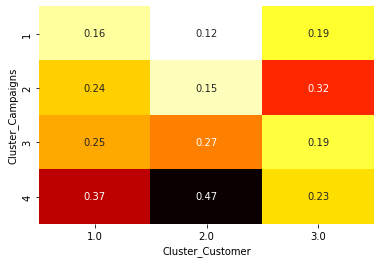

In [ ]:
sns.heatmap(pd.crosstab(resultado_train.Cluster_Campaigns, resultado_train.Cluster_Customer, values = np.array(resultado_train.iloc[:,2]), aggfunc = 'mean'),
            cmap="hot_r", annot=True, cbar=False)

Los resultados de los 5 clientes simulados serán: 

* Cliente Simulado 1, pertenece al cluster de clientes 2, por lo que, con un 47% de probabilidad de éxito, se le deberá ofrecer una campaña perteneciente al segundo cluster de campañas

* Cliente Simulado 2, pertenece al cluster de clientes 1, por lo que, con un 37% de probabilidad de éxito, se le deberá ofrecer una campaña perteneciente al segundo cluster de campañas

* Cliente Simulado 3, pertenece al cluster de clientes 1, por lo que, con un 37% de probabilidad de éxito, se le deberá ofrecer una campaña perteneciente al segundo cluster de campañas

* Cliente Simulado 4, pertenece al cluster de clientes 3, por lo que, con un 32% de probabilidad de éxito, se le deberá ofrecer una campaña perteneciente al cuarto cluster de campañas

* Cliente Simulado 5, pertenece al cluster de clientes 2, por lo que, con un 47% de probabilidad de éxito, se le deberá ofrecer una campaña perteneciente al segundo cluster de campañas

Con los resultados obtenidos, se me ocurre hacer un análisis de la eficiencia de cada uno de los clusters de campañas. Las campañas que pertenezcan a los clusters 1 o 3 nunca van a ser escogidas como optimas para ofrecer a los clientes según la agrupación en 3 clusters de clientes, por lo que le podríamos decir al director de marketing que elimine las campañas que pertenecen a estos clusters, ya que antes de aplicarlas, sería mejor aplicar las de otros clusters (realmente podría habrá campañas en estos clusters que tengan mejor resultados sobre los clientes que algunas de las que pertenecen a los clusters dominantes, pero me parecía un análisis interesante de marcar)

> Si estamos ante un cliente de cluster 1, lo optimo seria una campaña de cluster de campañas 2 ya que es la oferta con mayor probabilidad de éxito

> Si estamos ante un cliente de cluster 2, lo optimo seria una campaña de cluster de campañas 2 ya que es la oferta con mayor probabilidad de éxito

> Si estamos ante un cliente de cluster 3, lo optimo seria una campaña de cluster de campañas 4 ya que es la oferta con mayor probabilidad de éxito


###Pregunta 6.2
Genera una campaña nueva simulada. ¿A que clúster de clientes le ofrecerías la campaña con el objetivo de maximizar el éxito?.

In [ ]:
centroides_5_campaign = scaler_campaigns.inverse_transform(centroides_5_campaigns)
Preg62 = pd.DataFrame(centroides_5_campaign, columns = campaigns_clean.columns[0:5])
Preg62['Cluster'] = kmeans_camp.fit_predict(centroides_5_campaigns)+1
Preg62

,prob_food,prob_drink,outdate,price,discount,Cluster
0,0.488462,0.378462,10.076923,30.206154,0.343846,3
1,0.166000,0.815200,1.360000,199.959600,0.048800,2
2,0.501600,0.452800,2.240000,39.626400,0.504800,1
3,0.809600,0.216000,7.960000,100.023200,0.052400,4
4,0.680000,0.443333,8.916667,29.807500,0.345833,3


En esta tabla se puede ver los valores que toma cada una de las 5 campañas generadas, son valores factibles matematicamente y en este caso tambien realmente, ademas de pertenecer al espacio dimensional.

He utilizado los 5 centroides de la ultima estimación del K medias que he hecho (con 5 clusters), de tal manera que son puntos factibles, pero que no son el centroide exacto de los 4 grupos, así tengo algo de variedad y no simplemente un individuo para cada uno de los 4 grupos (es decir, la predicción que hago ahora, la someto a 4 grupos, siendo que los centroides se han determinado con 5 grupos). Si cogiese los centroides de 4 grupos, tambien serían factibles, pero no estaría prediciendo nada nuevo, me daría que pertenece cada uno a un grupo (al ser el centroide)

He utilizado el Kmedias de la pregunta 3 para predecir el cluster al que pertenece cada una de ellas y he registrado esa variable en la ultima columna.

A continuación he creado una tabla de doble entrada que representa todas las combinaciones posibles de cluster-campaña y las probabilidades de éxito de cada combinacion segun los datos de entrenamiento (la diferencia con los datos de test es minima,por lo que podría haberlos usado con resultados muy similares

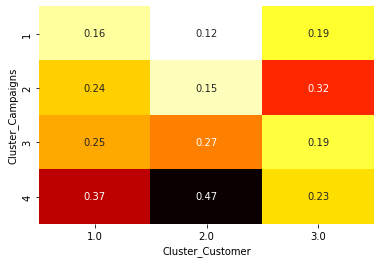

In [ ]:
sns.heatmap(pd.crosstab(resultado_train.Cluster_Campaigns, resultado_train.Cluster_Customer, values = np.array(resultado_train.iloc[:,2]), aggfunc = 'mean'),
            cmap="hot_r", annot=True, cbar=False)

Los resultados de los 5 clientes simulados serán: 

* Campaña Simulada 1, pertenece al cluster de campañas 3, por lo que, con un 27% de probabilidad de éxito, se le deberá ofrecer a un cliente perteneciente al segundo cluster de clientes

* Campaña Simulada 2, pertenece al cluster de campañas 2, por lo que, con un 47% de probabilidad de éxito, se le deberá ofrecer a un cliente perteneciente al segundo cluster de clientes

* Campaña Simulada 3, pertenece al cluster de campañas 1, por lo que, con un 19% de probabilidad de éxito, se le deberá ofrecer a un cliente perteneciente al tercer cluster de clientes

* Campaña Simulada 4, pertenece al cluster de campañas 4, por lo que, con un 32% de probabilidad de éxito, se le deberá ofrecer a un cliente perteneciente al tercer cluster de clientes

* Campaña Simulada 5, pertenece al cluster de campañas 3, por lo que, con un 27% de probabilidad de éxito, se le deberá ofrecer a un cliente perteneciente al segundo cluster de clientes

Con los resultados obtenidos, se me ocurre hacer un análisis de la eficiencia de cada uno de los clusters de clientes. Realmente, no hay ningun cluster de campañas que se deba enfocar directamente al primer cluster de clientes, ya que siempre tendrá mayor probabilidad de éxito enfocarlo a clientes pertenecientes a los clusters de clientes dos o tres.

> Si estamos ante una campaña de cluster 1, lo optimo seria enfocarlo a un cliente del cluster 3 ya que es el enfoque de mayor probabilidad de éxito

> Si estamos ante una campaña de cluster 1, lo optimo seria enfocarlo a un cliente del cluster 2 ya que es el enfoque de mayor probabilidad de éxito

> Si estamos ante una campaña de cluster 1, lo optimo seria enfocarlo a un cliente del cluster 2 ya que es el enfoque de mayor probabilidad de éxito

> Si estamos ante una campaña de cluster 1, lo optimo seria enfocarlo a un cliente del cluster 3 ya que es el enfoque de mayor probabilidad de éxito

### Pregunta 7. Realiza una optimización de tus modelos. 
Haciendo uso de los conocimientos de diferentes técnicas de clustering que conoces, y sus diferentes parámetros. Prueba diferentes combinaciones (todas las que quieras) para clusterizar tanto las campañas y los clientes y evalúalas contra el dataset de validación. Quédate con aquella que tenga el error cuadrático más pequeño.  Una vez elegida la mejor combinación, evalúala contra el dataset de test. TIPS: puedes incluso combinar el hacer un PCA primero antes de aplicar clustering.

In [ ]:
#c2c_train, c2c_test = train_test_split(camp2cust, test_size=0.2, random_state=123)
#c2c_train, c2c_validation = train_test_split(c2c_train, test_size=0.25, random_state=123)

En este ultimo ejercicio, al ser voluntario, he querido complicarlo lo máximo posible y buscar la mejor solucion para el problema de negocio que se nos ha planteado. Por ello, he realizado una transformación de los datos un tanto distinta y sobre esta he aplicado 5 algoritmos clustering distintos:
* 1.- K means
* 2.- Agrupación Jerárquica
* 3.-DBSCAN
* 4.- Gaussian Mixture
* 5.- HDBSCAN

Estos 5 algoritmos los he aplicado teniendo en cuenta el optimo de inputs en cada caso (epsilon y minimo en la muestra para el DBSCAN, k optimo en el K medias o la altura de corte en el jerárquico) repitiendo el análisis para train y para test para poder obtener el (Root) Error Cuadrático Medio (RMSE) de cada algoritmo, comparando las predicciones que hace para los clientes y campañas de test y train.

La estructura de mi respuesta es la siguiente:

* Primero, he tratado los datos y he creado una función para obtener el RMSE que ahora comentaré

* Segundo, he calculado la predicción del cluster de pertenencia para cada cliente y campaña según los 5 algoritmos mencionados 

* Tercero, he analizado el resultado sobre los datos de entrenamiento y de test, obteniendo la prediccion del éxito de aplicar cada cluster de campañas a cada cluster de clientes.

* Cuarto, caluclar el Root Mean Square Error para cada algoritmo de clustering

* Quinto, hacer un cuadro resumen con todo el proceso anterior, para ver y comparar de una sola vez todo el análisis.

A continuación realizo el tratamiento de datos, muy similar al de la práctica, yelimino los outliers, escalo los datos y realizo el PCA para poder graficar los resultados de los algoritmos.

Me he planteado aplicar los algoritmos de clustering sobre el PCA directamente, de esta manera, la información repetida en varias columnas no tendría tanto efecto sobre el cluster, pero los RMSE que arrojaban los modelos eran un tanto superiores,por lo que he decidido aplicarlo directamente sobre los datos tratados y escalados, pero no sobre las CP.

In [ ]:
customers_Extra = customers.drop(columns=['Response', 'customer_id', 'Z_Revenue', 'Z_CostContact'])
customers_Extra['Income'] = customers_Extra['Income'].fillna(customers_Extra.Income.mean(), inplace=False) 
customers_Extra['Marital_Status'] = customers_Extra['Marital_Status'].apply(lambda id: {'Married': 'Married', 'Together': 'Together', 'Single': 'Single', 'Divorced': 'Divorced',
                                                                            'Widow': 'Widow', 'Alone': 'Single', 'YOLO': 'Single', 'Absurd': 'Single'}[str(id)])
customers_Extra = ce.OneHotEncoder(cols = ['Marital_Status']).fit(customers_Extra).transform(customers_Extra)
customers_Extra['Education'] = customers['Education'].apply(lambda id: {'Basic': 1,'2n Cycle': 2, 'Graduation': 3,'Master': 4, 'PhD': 5}[str(id)])
customers_Extra['Edad'] = 2022-customers_Extra['Year_Birth']
customers_Extra['Dt_Customer'] = ((int(time.time())) - (pd.to_datetime(customers['Dt_Customer']).astype(int)/10**9))/(60*60*24*365)
customers_Extra = customers_Extra.drop(columns=['Year_Birth', 'Marital_Status_5'])

customers_Extra.head()

,Education,Marital_Status_1,Marital_Status_2,Marital_Status_3,Marital_Status_4,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Edad
0,3,1,0,0,0,58138.0,0,0,9.387236,58,635,88,546,172,88,88,3,8,10,4,7,0,65
1,3,1,0,0,0,46344.0,1,1,7.880386,38,11,1,6,2,1,6,2,1,1,2,5,0,68
2,3,0,1,0,0,71613.0,0,0,8.425592,26,426,49,127,111,21,42,1,8,2,10,4,0,57
3,3,0,1,0,0,26646.0,1,0,7.951619,26,11,4,20,10,3,5,2,2,0,4,6,0,38
4,5,0,0,1,0,58293.0,1,0,8.011893,94,173,43,118,46,27,15,5,5,3,6,5,0,41


In [ ]:
customers_Extra['Outlier'] = y_pred_x
customers_clean_extra = customers_Extra[customers_Extra.Outlier.isin([0])].drop(columns=['Outlier'])
customers_clean2_scaled = StandardScaler().fit_transform(customers_clean_extra.select_dtypes(np.number))

In [ ]:
from sklearn.decomposition import PCA
PCA = PCA(n_components = 11)
pca = PCA.fit(customers_clean2_scaled)
projected = pca.fit_transform(customers_clean2_scaled)

Lo siguiente que hago es una función que calcule el Root Mean Square Error. 
Con esta función, consigo simplificar el proceso de predicción del éxito para cada uno de las combinaciones de cluster cliente - cluster campaña tanto para train y para test, asi como el calculo del RMSE

* Toma como imput el cluster al que pertenece cada cliente y campaña según el algoritmo de clustering de cada caso.

* Despues, guarda ese dato en una nueva columna de los datos tratados anteriormente de clientes y de campañas

* A continuación, hace el doble join entre los clusters de clientes, la tabla de resultados de train y los clusters de campañas. Seguidamente, repite el proceso pero con la tabla de resultados de test.

* Lo siguiente que hace es agrupar los datos y calcular laprobabilidad de éxito de cada combinacion cluster cliente- cluster campaña, tanto para los datos de entrenamiento como para los datos de test. 

* Por ultimo, devuelve la raiz cuadrada del Error Cuadrático Medio para poder comparar los valores en cada uno de los 5 algoritmos de clustering

Esta función me ha permitido simplificar mi siguiente código, ya que simplemente he tenido que calcular el cluster al que pertenece cada cliente y campaña en cada uno de los 5 algoritmos de clustering para despues aplicar la funcion y obtener el RMSE automaticamente, evitando escribir una gran cantidad de código y evitando tambien posibles fallos.

In [ ]:
def obtain_RMSE(cluster_clientes, cluster_campaigns):
   clus_cust = customers_clean_extra
   clus_cust['Cluster_Customer'] = cluster_clientes + 1
   clus_camp = campaigns_clean
   clus_camp['Cluster_Campaigns'] = cluster_campaigns + 1

   join_train = c2c_train.set_index('campaign')
   join_train = join_train.join(clus_camp).join(clus_cust, on = 'customer').reset_index()
   join_train['unos'] = [1]*len(join_train) 
   
   grouped = join_train.groupby(['Cluster_Campaigns', 'Cluster_Customer']).sum()
   resultado_train = grouped.result/grouped.unos

   join_test = c2c_test
   join_test = join_test.join(clus_camp).join(clus_cust, on = 'customer').reset_index()
   join_test['unos'] = [1]*len(join_test) 

   grouped = join_test.groupby(['Cluster_Campaigns', 'Cluster_Customer']).sum()
   resultado_test = grouped.result/grouped.unos

   return math.sqrt(mean_squared_error(resultado_train, resultado_test))

#### K-Medias
He calculado, sobre los datos tratados, el cluster al que pertenece cada cliente o campaña según el algoritmo de K-medias, teniendo en cuenta el óptimo número de clusters que tiene en cada caso según el método del codo que se presenta en el cuadro final

He guardado la información resultante en dos variables para emplearlas en el resumen.

In [ ]:
kmeans_cust = KMeans(n_clusters=3, random_state=123, max_iter = 10000)
y_pred_clientes = kmeans_cust.fit_predict(customers_clean2_scaled)

kmeans_camp = KMeans(n_clusters=4, random_state=123, max_iter = 10000)
y_pred_campaign = kmeans_camp.fit_predict(campaigns_clean_scaled)

#### Agrupación Jerárquica

He calculado, sobre los datos tratados, el cluster al que pertenece cada cliente o campaña según el algoritmo jerárquico de agrupación, teniendo en cuenta el óptimo número de clusters que tiene en cada caso según el método del codo que se presenta en el cuadro final. Además, he analizado el dendograma resultante para campañas y para clientes en el resumen.

He guardado la información resultante en dos variables para emplearlas en el resumen.

In [ ]:
clusterer = AgglomerativeClustering(n_clusters=3)
clusters_cust = clusterer.fit_predict(customers_clean2_scaled)

clusterer = AgglomerativeClustering(n_clusters=4)
clusters_camp = clusterer.fit_predict(campaigns_clean_scaled)

#### DBSCAN

He calculado, sobre los datos tratados, el cluster al que pertenece cada cliente o campaña según el algoritmo de DBSCAN, teniendo en cuenta el óptimo epsilon que tiene en cada caso según el método del codo que se presenta en el cuadro final, y el numero minimo de muestras como dos veces la longitud de los datos como se explica en elDBSCAN aplicado en la pregunta 2 de la práctica.

He guardado la información resultante en dos variables para emplearlas en el resumen.

In [ ]:
clustering2 = DBSCAN(eps = 3.5, min_samples=np.shape(customers_clean2_scaled)[1]*2).fit(customers_clean2_scaled)
y_pred_cus = clustering2.fit_predict(customers_clean2_scaled)

clustering2 = DBSCAN(eps = 0.9, min_samples=np.shape(campaigns_clean_scaled)[1]*2).fit(campaigns_clean_scaled)
y_pred_camp = clustering2.fit_predict(campaigns_clean_scaled)

#### Gaussian Mixture

He calculado, sobre los datos tratados, el cluster al que pertenece cada cliente o campaña según el modelo de Gaussian Mixture, teniendo en cuenta el óptimonúmero de clusters según la gráfica del codo. He guardado la información resultante en dos variables para emplearlas en el resumen.

In [ ]:
gmm = GaussianMixture(n_components=3, max_iter =1000000,covariance_type = 'full',random_state = 123)
y_pred_customers = gmm.fit_predict(customers_clean2_scaled)

gmm = GaussianMixture(n_components=4, max_iter =1000000,covariance_type = 'full',random_state = 123)
y_pred_campa = gmm.fit_predict(campaigns_clean_scaled)

#### HDBSCAN

He calculado, sobre los datos tratados, el cluster al que pertenece cada cliente o campaña según el algoritmo HDBSCAN, al ser la primera vez que implementaba este algoritmo, he obtenido informacion de la siguiente <a href="https://rubialesalberto.medium.com/clustering-con-dbscan-y-hdbscan-con-python-y-sus-hiperpar%C3%A1metros-en-sklearn-8728283b96ac">publicación</a>. 

In [ ]:
hdbscan = HDBSCAN(min_cluster_size=50, min_samples=5)
preds_2_cus = hdbscan.fit_predict(customers_clean2_scaled)

hdbscan = HDBSCAN(min_cluster_size=20, min_samples=5)
preds_2_camp = hdbscan.fit_predict(campaigns_clean_scaled)

### Cuadro Resumen

En el siguiente cuadro, he querido recoger de un golpe la información que he obtenido en esta pregunta 7, con 16 gráficas distintas y calculando 5 RMSE gracias a la función que he creado previamente. 

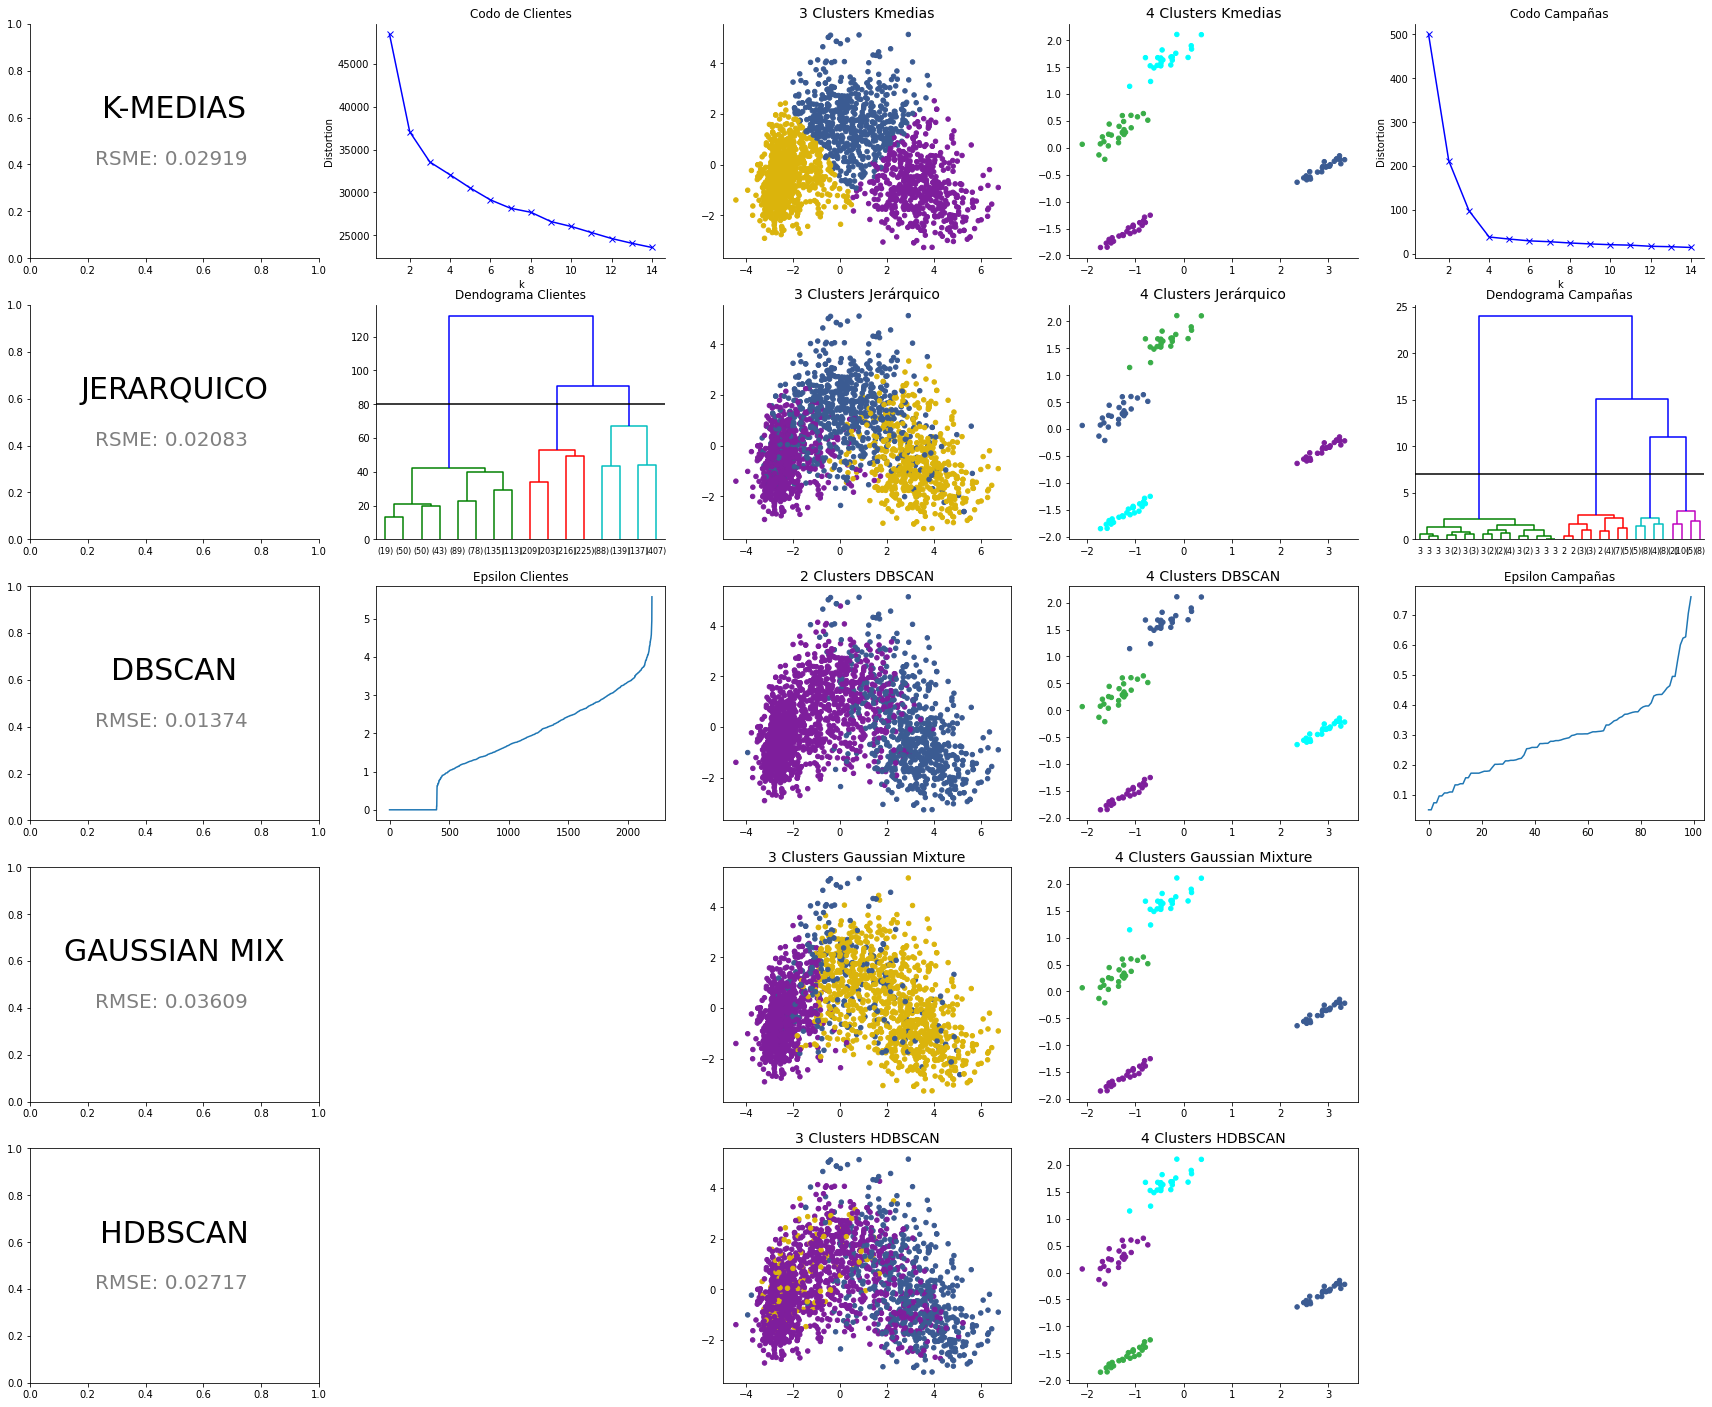

In [ ]:
plt.figure(figsize=(30,25))

plt.subplot(551)
plt.text(0.5, 0.6, "K-MEDIAS", ha='center', fontsize=30, color='black')
plt.text(0.5, 0.4, "RSME: {} ".format(round(obtain_RMSE(y_pred_clientes, y_pred_campaign),5)),ha='center', fontsize=20, color='grey')
plt.subplot(552)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(customers_clean2_scaled)
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Codo de Clientes')

plt.subplot(553)
plt.scatter(projected[:,0], projected[:,1], c=y_pred_clientes, s=20, cmap=cmap)
plt.title('3 Clusters Kmedias', fontsize=14)

plt.subplot(554)
plt.scatter(data[:,0], data[:,1], c=y_pred_campaign, s=20, cmap=cmap)
plt.title('4 Clusters Kmedias', fontsize=14)

plt.subplot(555)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(campaigns_clean_scaled)
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Codo Campañas')

plt.subplot(556)
plt.text(0.5, 0.6, "JERARQUICO", ha='center', fontsize=30, color='black')
plt.text(0.5, 0.4, "RSME: {} ".format(round(obtain_RMSE(clusters_cust, clusters_camp),5)),ha='center', fontsize=20, color='grey')

plt.subplot(557)
Z = linkage(customers_clean2_scaled, 'ward')
dendrogram(Z, labels=clusters_cust, orientation='top', leaf_rotation=0., leaf_font_size=8., truncate_mode='level', p=3, color_threshold = 80)
sns.despine()
plt.axhline(y=80, c='k')
plt.title('Dendograma Clientes')

plt.subplot(558)
plt.scatter(projected[:,0], projected[:,1], c=clusters_cust, s=20, cmap=cmap)
plt.title('3 Clusters Jerárquico', fontsize=14)

plt.subplot(559)
plt.scatter(data[:,0], data[:,1], c=clusters_camp, s=20, cmap=cmap)
plt.title('4 Clusters Jerárquico', fontsize=14)

plt.subplot(5,5,10)
Z = linkage(campaigns_clean_scaled, 'ward')
dendrogram(Z, labels=clusters_camp, orientation='top', leaf_rotation=0., leaf_font_size=8., truncate_mode='level', p=4, color_threshold = 7)
sns.despine()
plt.axhline(y=7, c='k')
plt.title('Dendograma Campañas')

plt.subplot(5,5,11)
plt.text(0.5, 0.6, "DBSCAN", ha='center', fontsize=30, color='black')
plt.text(0.5, 0.4, "RMSE: {} ".format(round(obtain_RMSE(y_pred_cus, y_pred_camp),5)),ha='center', fontsize=20, color='grey')

plt.subplot(5,5,12)
neighbors_fit = neighbors.fit(customers_clean2_scaled)
distances, indices = neighbors_fit.kneighbors(customers_clean2_scaled)
distances = np.sort(distances, axis=0)                           
distances = distances[:,1]
plt.plot(distances)
plt.title('Epsilon Clientes')

plt.subplot(5,5,13)
plt.scatter(projected[:,0], projected[:,1], c=y_pred_cus, s=20, cmap=cmap)
plt.title('2 Clusters DBSCAN', fontsize=14)

plt.subplot(5,5,14)
plt.scatter(data[:,0], data[:,1], c=y_pred_camp, s=20, cmap=cmap)
plt.title('4 Clusters DBSCAN', fontsize=14)

plt.subplot(5,5,15)
neighbors_fit = neighbors.fit(campaigns_clean_scaled)
distances, indices = neighbors_fit.kneighbors(campaigns_clean_scaled)
distances = np.sort(distances, axis=0)                           
distances = distances[:,1]
plt.plot(distances)
plt.title('Epsilon Campañas')

plt.subplot(5,5,16)
plt.text(0.5, 0.6, "GAUSSIAN MIX", ha='center', fontsize=30, color='black')
plt.text(0.5, 0.4, "RMSE: {} ".format(round(obtain_RMSE(y_pred_customers, y_pred_campa),5)),ha='center', fontsize=20, color='grey')

plt.subplot(5,5,18)
plt.scatter(projected[:,0], projected[:,1], c=y_pred_customers, s=20, cmap=cmap)
plt.title('3 Clusters Gaussian Mixture', fontsize=14)

plt.subplot(5,5,19)
plt.scatter(data[:,0], data[:,1], c=y_pred_campa, s=20, cmap=cmap)
plt.title('4 Clusters Gaussian Mixture', fontsize=14)

plt.subplot(5,5,21)
plt.text(0.5, 0.6, "HDBSCAN",ha='center', fontsize=30, color='black')
plt.text(0.5, 0.4, "RMSE: {} ".format(round(obtain_RMSE(preds_2_cus, preds_2_camp),5)),ha='center', fontsize=20, color='grey')

plt.subplot(5,5,23)
plt.scatter(projected[:,0], projected[:,1], c=preds_2_cus, s=20, cmap=cmap)
plt.title('3 Clusters HDBSCAN', fontsize=14)

plt.subplot(5,5,24)
plt.scatter(data[:,0], data[:,1], c=preds_2_camp, s=20, cmap=cmap)
plt.title('4 Clusters HDBSCAN', fontsize=14)

plt.show()

El primero de los algoritmos que he aplicado ha sido el K medias con un error cuadratico medio de 0,029 lo que es un valor realmente bajo.

* He hecho dos gráficas de codo, una para clientes y otra para campañas. Se parecen mucho a las realizadas en la práctica, ya que los datos son similares.  

 Se puede ver como el óptimo de cluster de clientes es 3 y el óptimo de cluster de campañas es 4 por lo tanto, son el número que utilizo para realizar el clustering.

* En el centro, se pueden ver las comparaciones de los distintos gráficos de sedimentación. En el caso de los clusters de K medias de clientes se ve perfectamente como se distribuyen los grupos de forma homogénea entre sí y heterogénea con el resto de puntos, sin generar ningún tipo de punto solapado.

 Está superposición de puntos es incluso menor en el caso de los clusters de campañas, es más, como ahora veremos, todos los algoritmos de clustering determinan la misma distribución de los puntos en cuatro clases de campañas

\
El siguiente de los algoritmos de clustering que he aplicado es el modelo de agrupación jerárquica. El error cuadratico medio que arroja es de 0,020, es decir, menor que en el caso del Kmedias. Aún así sigue siendo mayor que otros algoritmos como ahora veremos.

* En este caso he realizado dos dendrogramas, uno para clientes y otro para campañas. Se puede ver en el dendograma de clientes como, cortando a una altura de 80, logramos generar tres clusters que se agrupan a distintas alturas. En el caso del primero de ellos a una altura de unos 40, en el caso del segundo, una altura de unos 50 y en el caso el tercero, a una altura de unos 70.

* Por otro lado, el dendograma de campañas permite cortarlo a una altura  incluso de 5 para generar 4 clusters diferenciados. En este caso, se agrupan a una altura de entorno a 3. 

* Gráficamente, vemos como en la sedimentación de los grupos de clientes, sí que se superponen unos a otros. Tenemos que recordar, que en esta gráfica tan solo se presentan las dos primeras componentes principales, por lo que puede ser que la discriminación entre grupos se de por una variable que no esté correctamente representada en estas componentes principales, lo que explicaría que pese, a que graficamente parece estar peor agrupado, realmente arroje un error cuadratico medio menor.

* En el caso de la sedimentación de campañas, como ya he dicho, se agrupa en cuatro grupos al igual que en todos los algoritmos, ya que están suficientemente separados y son muy homogéneos intragrupo y muy heterogéneos intergrupos

\
El siguiente algoritmo que he aplicado, ha sido el DBSCAN. En este caso he obtenido el menor error cuadratico medio de todos 0,013 lo que se puede deber a que tan solo se han generado dos clusters en los datos de clientes.

* En un primer lugar voy a comentar las gráficas de codo que determinan el épsilon qué se utiliza en cada uno de los algoritmos que he implementado.
 
* El epsilon del codo de clientes que genera el cambio hacia la verticalidad se da en 3,5, por lo tanto, es el épsilon que he utilizado para agrupar los puntos, es decir, el radio del círculo que determina si un punto pertenece a un grupo o a otro es de 3,5.

* En el caso del epsilon de las campañas, la verticalidad se consigue con un valor de 0,9, que ha sido el radio que he utilizado para el algoritmo de clustering.

* Graficamente, se ve como en el caso de los clientes tan solo se han generado dos grupos con esta combinación de épsilon y número mínimo de datos, lo cual puede ser el condicionante para generar un error cuadratico medio menor que en el caso de algoritmos. En el caso de campañas, seguimos como en el resto de algoritmos.

\
En el caso de el algoritmo Gaussiano, he obtenido un error cuadratico medio de 0,03 lo cual es un tanto mayor a lo que vengo obteniendo.

* No he necesitado realizar ningún análisis previo, ya que el número de clusters es el mismo que utilizado en el k-medias a traves de las graficas del codo.

* Gráficamente, en la sedimentación de los individuos, veo como se superponen los grupos. Esto puede generar un mayor error cuadratico medio o simplemente deberse a que la discriminación entre un grupo u otro no está correctamente representada en las dos primeras componentes principales.

* En el caso de los campañas, no hay sorpresa, y se agrupan igual que en el resto de algoritmos

\
Por último, me parecía interesante aplicar un HDBSCAN, ya que nunca he aplicado uno y me parece que pueda ajustarse correctamente a la estructura de los datos.

* He obtenido un error cuadratico medio de 0,02 lo cual es bastante bajo, teniendo en cuenta que es menor que el de k-medias.

* En este caso, para poder implementarlo, he utilizado la librería HDBSCAN siguiendo las pautas que se indican en la publicación que ya he mencionado.

* Graficamente se ve como la sedimentación de clientes es bastante parecida a la del DBSCAN a excepción de incluir otro grupo más que podrían ser considerados como individuos fuera de rango.

* En el caso de las campañas se sigue agrupando igual que en otros algoritmos

\
Para hacer una conclusión de el algoritmo óptimo para tratar cada dato, he tenido en cuenta que la estructura que posee cada una de las dos tablas de clientes y de campañas, es distinta, por lo que el algoritmo que mejor se adapte a cada tipo de dato es distinto.

Por lo tanto y teniendo en cuenta el resultado que arroja cada uno de los algoritmos, creo que en el caso de los datos de campañas cualquiera de ellos puede agruparlos correctamente ya que no hay ninguna diferencia. Esto se debe a que los datos son suficientemente homogéneos dentro de cada grupo y heterogéneos para discriminarse de otros grupos. Finalmente creo que el K-medias es el más fácil de implementar y más sencillo determinar sus inputs óptimos (es decir, simplemente con la gráfica del codo) por lo que para la agrupación de campañas utilizaría el K-medias.

En el caso de los datos de clientes, me parece que el algoritmo que mejor separa los grupos es el DBSCAN con dos clusters, ya que es el que minimiza el error cuadratico medio, si bien es cierto que elimina uno de los grupos lo cual perjudicaría algunas decisiones de negocio.

Pensandolo ahora, puede ser que el óptimo de clusters de clientes a agrupar en el Kmedias de la practica sean 2 y no 3, esto explicaría que en la pregunta 6, haya un cluster de clientes al que, de primeras, no se le ofrecería ninguna campaña (ya que no generaría tanto éxito como ofreciendosela a otro cluster de clientes).

Puede ser que simplemente haya 2 clusters de clientes, de tal manera que los que pertenecen a el grupo ineficiente, se integrarían en los otros clusters. 

Pese a esto, he de decir que hay campañas concretas cuyo resultado de éxito es óptimo al ofrecerse al cluster que podría ser eliminado, por lo que si bien, no podemos decir que estos indviduos deberían agruparse en otro de los dos clusters, dentro de este, se generaría un subgrupo concreto sobre el que tendría un mejor efecto ciertas campañas concretas.

A nivel de negocio, podemos decir que la empresa tiene 4 tipos de campaña muy bien diferenciados, es decir, podríamos determinar que hay cuatro lineas de producto correctamente diferenciadas.

Sin embargo, a la hora de hablar de los clientes a los que ofrecemos esas líneas de producto, encontramos que, o bien hay tres grupos generales de clientes los cuales van a tener un impacto diferente cada una de las campañas que ofrezcamos, o bien hay tan solo dos grupos de clientes a los que se enfocarán unas u otras campañas y dentro de uno de esos grupos de clientes hay un subgrupo, que no es suficientemente numeroso como para ser un tercer grupo, pero si como para poder enfocar ciertas campañas a un nicho de mercado. 
Además, teniendo en cuenta la similitud entre los outliers que hemos eliminado en la práctica, podríamos llegar a decir que la empresa está buscando enfocarse a un nuevo tipo de cliente, completamente distinto al habitual pero que generaría un grupo de mercado nuevo.
